## RQ2 - How does difficulty influence retention rates on the platform?

In [1]:
import pandas as pd 
import numpy as np 
import json
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import pairwise_distances_argmin, RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score, f1_score, classification_report, r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

In [2]:
transactions = pd.read_csv('/Users/valentine/mlbd-2025/project/Lernnavi/Lernnavi_Data/transactions.csv.gz')
documents = pd.read_csv('/Users/valentine/mlbd-2025/project/Lernnavi/Lernnavi_Data/documents.csv.gz')

In [113]:
Math_color = '#DD8888'
German_color = '#D81515FF'

### Preprocessing

In [3]:
# Get question difficulties

def get_difficulty(doc):
    res = None
    doc = json.loads(doc)
    if doc.get('metaData') != None:
        res = doc.get('metaData').get('estimatedDifficulty')
    return res

documents['difficulty'] = documents['content'].apply(lambda doc: get_difficulty(doc))

In [4]:
# Merge transactions and documents

documents.rename(columns={'version': 'document_version'}, inplace=True)
difficulty = pd.merge(transactions, documents, on=['document_id', 'document_version'])
difficulty.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,challenge_name,title,type_y,created_time,author_id,content,status,version_comment,topic_id_y,difficulty
0,688413,88fdcaad-f73b-46a2-b561-d262f2441442,393211,awd0i1DlVtg6kuMZSkpmHa,75002,PARTIAL,"{""type"": ""MULTI_COLOR_HIGHLIGHT"", ""highlighted...",2021-05-21 07:58:27.312000000,2021-05-21 08:03:43.020000000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6...,...,G3h – Training Rhetorik,6.3A_STIL_RHET_16,MULTI_COLOR_HIGHLIGHT,2021-04-12 19:46:20.635,29.0,"{""id"": ""awd0i1DlVtg6kuMZSkpmHa"", ""type"": ""MULT...",LIVE,NaN,2045,2.0
1,688414,a75eb7b4-b2c2-47d4-9200-27980c175037,393211,arhWF3BT53V9W8cGOaZVPX,75012,PARTIAL,"{""type"": ""MULTI_COLOR_HIGHLIGHT"", ""highlighted...",2021-05-21 08:04:05.067000000,2021-05-21 08:07:21.288999936,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6...,...,G3h – Training Rhetorik,6.3_STIL_RHET_11,MULTI_COLOR_HIGHLIGHT,2021-04-12 19:49:26.297,29.0,"{""id"": ""arhWF3BT53V9W8cGOaZVPX"", ""type"": ""MULT...",LIVE,NaN,4256,3.0
2,688415,61eb829d-bdda-4107-86af-ad9a14a7bdc9,393211,9wk5dtV2mF59odW0wCEYYc,75003,PARTIAL,"{""type"": ""CLOZE_TEXT"", ""clozeInputs"": [""Person...",2021-05-21 08:07:37.048000000,2021-05-21 08:13:30.953999872,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6...,...,G3h – Training Rhetorik,6.3_STIL_RHET_5,CLOZE_TEXT_INPUT,2021-04-12 19:48:16.679,29.0,"{""id"": ""9wk5dtV2mF59odW0wCEYYc"", ""type"": ""CLOZ...",LIVE,NaN,4256,3.0
3,688416,30ff0d8a-865d-460b-9177-b698a52b0d5c,393211,afilxZ8LycP5LReULeKngW,75009,CORRECT,"{""type"": ""DND_PAIRS"", ""input"": [""<p>Ich gehe i...",2021-05-21 08:13:38.943000000,2021-05-21 08:22:13.975000064,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6...,...,G3h – Training Rhetorik,6.3_STIL_RHET_7,DND_PAIRS,2021-04-12 19:49:06.392,29.0,"{""id"": ""afilxZ8LycP5LReULeKngW"", ""type"": ""DND_...",LIVE,NaN,4256,3.0
4,688417,0adedf3b-ba35-4497-8c6b-b5c2f6fcbbf3,393211,76m6v05NCeX8x2Wr5tKRE3,75007,CORRECT,"{""type"": ""DND_PAIRS"", ""input"": [""<p>Kleiner Ma...",2021-05-21 08:22:19.391000000,2021-05-21 08:22:55.366000128,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6...,...,G3h – Training Rhetorik,6.3_STIL_RHET_4,DND_PAIRS,2021-04-12 19:48:42.300,29.0,"{""id"": ""76m6v05NCeX8x2Wr5tKRE3"", ""type"": ""DND_...",LIVE,NaN,4256,2.0


In [5]:
# Create a perceived difficulty variable based on evaluation and time to answer 

difficulty['date'] = pd.to_datetime(difficulty['start_time'])
difficulty['year_week'] = difficulty['date'].dt.strftime('%Y-%U')
difficulty['time_to_answer'] = (pd.to_datetime(difficulty['commit_time']) - pd.to_datetime(difficulty['start_time'])).dt.total_seconds()

# Map evaluation values to weights
eval_map = {
    'CORRECT': 0.5,
    'PARTIAL': 1.0,
    'WRONG': 1.5,
    np.nan: 1.2  # Assume NaN means unclear result, treat as partially wrong
}
difficulty['evaluation_weight'] = difficulty['evaluation'].map(eval_map)

# Normalize time_to_answer (already in seconds) using log transform + z-score
difficulty['log_time'] = np.log1p(difficulty['time_to_answer'])
difficulty['normalized_time'] = (difficulty['log_time'] - difficulty['log_time'].mean()) / difficulty['log_time'].std()

# Compute perceived difficulty as interaction of time and evaluation weight
difficulty['perceived_difficulty'] = difficulty['normalized_time'] * difficulty['evaluation_weight']

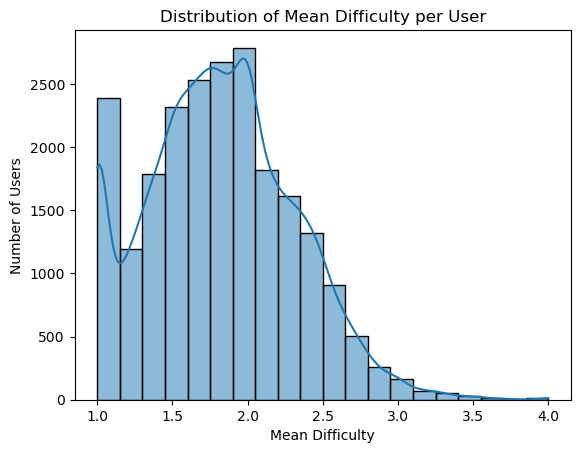

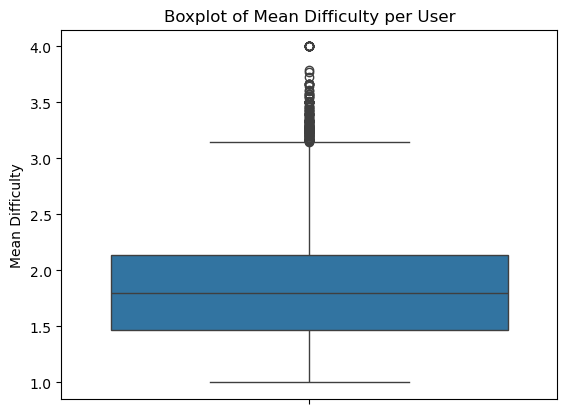

In [6]:
# Observe distribution of question difficulty 

# Mean difficulty
mean_diff = difficulty.groupby(['user_id', 'year_week'])['difficulty'].mean().reset_index(name='mean_difficulty')

# Count of each difficulty
counts = pd.pivot_table(
    difficulty,
    index=['user_id', 'year_week'],
    columns='difficulty',
    aggfunc='size',
    fill_value=0
).reset_index()

# Rename columns
counts.columns.name = None
counts = counts.rename(columns={
    1: 'difficulty_1_count',
    2: 'difficulty_2_count',
    3: 'difficulty_3_count',
    4: 'difficulty_4_count'
})

# Merge
weekly_difficulty = pd.merge(mean_diff, counts, on=['user_id', 'year_week'])
user_mean_difficulty = weekly_difficulty.groupby('user_id')['mean_difficulty'].mean().reset_index()

sns.histplot(user_mean_difficulty['mean_difficulty'], bins=20, kde=True)
plt.title('Distribution of Mean Difficulty per User')
plt.xlabel('Mean Difficulty')
plt.ylabel('Number of Users')
plt.show()

sns.boxplot(y=user_mean_difficulty['mean_difficulty'])
plt.title('Boxplot of Mean Difficulty per User')
plt.ylabel('Mean Difficulty')
plt.show()

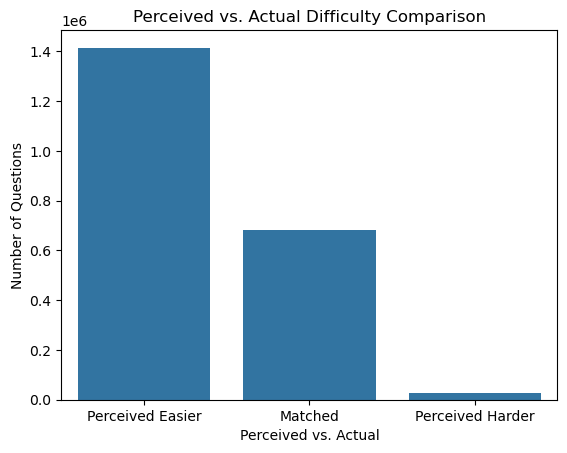

In [7]:
# Show perceived vs actual difficulty

threshold = 0.5
difficulty['perceived_vs_actual'] = difficulty.apply(
    lambda row: -1 if row['perceived_difficulty'] < row['difficulty'] - threshold
    else (1 if row['perceived_difficulty'] > row['difficulty'] + threshold 
    else 0),
    axis=1
)
# Create label names for readability
label_map = {-1: 'Perceived Easier', 0: 'Matched', 1: 'Perceived Harder'}
difficulty['perceived_label'] = difficulty['perceived_vs_actual'].map(label_map)

# Plot
sns.countplot(data=difficulty, x='perceived_label', order=['Perceived Easier', 'Matched', 'Perceived Harder'])
plt.title('Perceived vs. Actual Difficulty Comparison')
plt.xlabel('Perceived vs. Actual')
plt.ylabel('Number of Questions')
plt.grid(False)
plt.show()

### Model engagement with difficulty

In [8]:
# Get engagement variable

user_week_features = pd.read_csv('/Users/valentine/mlbd-2025/project/Lernnavi/Lernnavi_Data/user_week_features.csv')

# Aggregate actual and perceived difficulty per user-week
weekly_difficulty_stats = difficulty.groupby(['user_id', 'year_week']).agg(
    mean_difficulty=('difficulty', 'mean'),
    std_difficulty=('difficulty', 'std'),
    mean_perceived=('perceived_difficulty', 'mean'),
    std_perceived=('perceived_difficulty', 'std'),
    perceived_minus_actual=('perceived_difficulty', lambda x: x.mean())  # we'll subtract later
).reset_index()

# Add perceived - actual difference
weekly_difficulty_stats['perceived_vs_actual_diff'] = (
    weekly_difficulty_stats['mean_perceived'] - weekly_difficulty_stats['mean_difficulty']
)

df_model = pd.merge(user_week_features, weekly_difficulty_stats, on=['user_id', 'year_week'], how='left').dropna()

In [9]:
user_week_features.head()

,user_id,year_week,weekly_events,weekly_clicks,weekly_time_spent,mean_session_duration,mean_days_between_sessions,weekly_go_to_theory,weekly_early_sessions,weekly_next_actions,weekly_skip_actions,weekly_percentage_correct,weekly_challenges_completed,std_weekly_activity,week_start,week_period,engaged_next_week
0,387604,2021-26,25,12.0,1.047106e+07,2.957527e+07,9.000000,0.0,0.0,0.0,7.0,0.0,0.0,141.95107,2021-06-27,2021-06-21/2021-06-27,0
1,387604,2021-33,93,23.0,3.437000e+00,3.437000e+00,6.000000,18.0,1.0,0.0,0.0,0.0,0.0,141.95107,2021-08-15,2021-08-09/2021-08-15,1
2,387604,2021-34,113,29.0,0.000000e+00,0.000000e+00,0.000000,50.0,0.0,0.0,0.0,0.0,0.0,141.95107,2021-08-22,2021-08-16/2021-08-22,1
3,387604,2021-35,405,111.0,8.352444e+04,6.424957e+03,0.846154,118.0,3.0,0.0,12.0,0.0,0.0,141.95107,2021-08-29,2021-08-23/2021-08-29,1
4,387604,2021-36,139,39.0,6.595295e+04,1.648824e+04,2.000000,27.0,1.0,0.0,0.0,0.0,0.0,141.95107,2021-09-05,2021-08-30/2021-09-05,1


#### Difficulty features only

In [10]:
# Define features and target
features = [
    'mean_difficulty',
    'std_difficulty',
    'mean_perceived',
    'std_perceived',
    'perceived_vs_actual_diff'
]

X = df_model[features]
y = df_model['engaged_next_week']

In [11]:
MODELS = {
    'Dummy'        : DummyClassifier(strategy='most_frequent'),
    'Logistic'     : LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest' : RandomForestClassifier(n_estimators=600, class_weight='balanced',
                                            n_jobs=-1, random_state=42),
    'GradientBoost': GradientBoostingClassifier(random_state=42)
}

def cross_val(pipe, X, y, cv):
    aucs, f1s = [], []
    for tr, te in cv.split(X):
        pipe.fit(X.iloc[tr], y.iloc[tr])
        p = pipe.predict_proba(X.iloc[te])[:,1]
        yhat = (p >= 0.5).astype(int)
        aucs.append(roc_auc_score(y.iloc[te], p))
        f1s.append( f1_score(y.iloc[te], yhat) )
    return np.mean(aucs), np.mean(f1s)

tscv = TimeSeriesSplit(n_splits=5)
rows = []

numeric_cols = X.select_dtypes(include='number').columns

pre = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
])

for name, clf in MODELS.items():

    pipe = make_pipeline(pre, clf)
    auc2, f12 = cross_val(pipe, X, y, tscv)
    rows.append({'model':name, 'AUC':auc2, 'F1':f12})

leader = pd.DataFrame(rows).sort_values(['AUC'], ascending=False).reset_index(drop=True)
display(leader.style.background_gradient(cmap='viridis', subset=['AUC','F1']))

best = leader.iloc[0]
print(f"\nBest: {best['model']} AUC={best['AUC']:.3f}")

# --------------------- 5 · fit on FULL data & save -----------------
best_clf = MODELS[best['model']]
final_pipe = make_pipeline(pre, best_clf)
final_pipe.fit(X, y)

,model,AUC,F1
0,Logistic,0.546949,0.503477
1,GradientBoost,0.531159,0.215981
2,RandomForest,0.519483,0.366389
3,Dummy,0.500000,0.000000



Best: Logistic AUC=0.547


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['mean_difficulty', 'std_difficulty', 'mean_perceived', 'std_perceived',
       'perceived_vs_actual_diff'],
      dtype='object'))])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

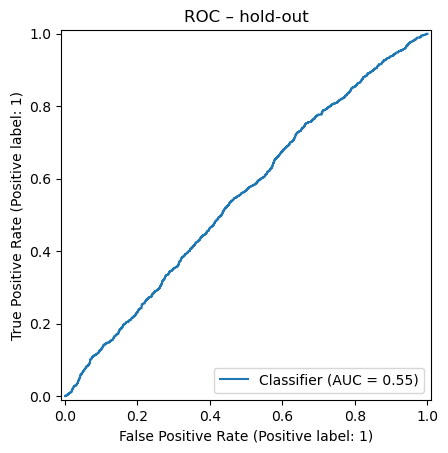

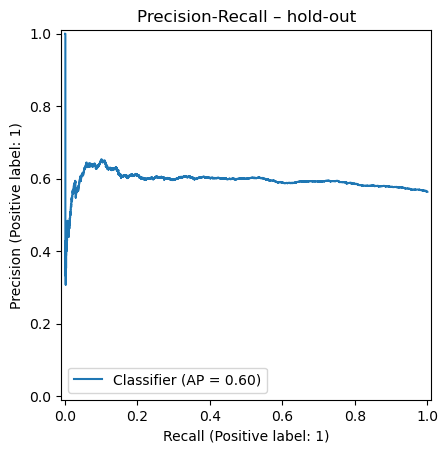

In [12]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, shuffle=False)
final_pipe.fit(X_train, y_train)
prob = final_pipe.predict_proba(X_hold)[:,1]

RocCurveDisplay.from_predictions(y_hold, prob)
plt.title('ROC – hold-out'); plt.show()

PrecisionRecallDisplay.from_predictions(y_hold, prob)
plt.title('Precision-Recall – hold-out'); plt.show()

With difficulty features only the model doesn't learn meaningful patterns

#### Difficulty and user features

In [13]:
# Drop ID columns from features
X = df_model.drop(columns=['user_id', 'year_week', 'engaged_next_week'])
y = df_model['engaged_next_week']

# -------------------------
# Modeling setup
# -------------------------
MODELS = {
    'Dummy'        : DummyClassifier(strategy='most_frequent'),
    'Logistic'     : LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest' : RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42),
    'GradientBoost': GradientBoostingClassifier(random_state=42)
}

numeric_cols = X.select_dtypes(include='number').columns

pre = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
])

def cross_val(pipe, X, y, cv):
    aucs, f1s = [], []
    for tr, te in cv.split(X):
        pipe.fit(X.iloc[tr], y.iloc[tr])
        p = pipe.predict_proba(X.iloc[te])[:,1]
        yhat = (p >= 0.5).astype(int)
        aucs.append(roc_auc_score(y.iloc[te], p))
        f1s.append(f1_score(y.iloc[te], yhat))
    return np.mean(aucs), np.mean(f1s)

tscv = TimeSeriesSplit(n_splits=5)
results = []

# -------------------------
# Train & Evaluate
# -------------------------
best_auc = -np.inf
best_pipe = None
best_model_name = None

for name, clf in MODELS.items():
    pipe = make_pipeline(pre, clf)
    auc, f1 = cross_val(pipe, X, y, tscv)
    results.append({'model': name, 'AUC': auc, 'F1': f1})

    # Save best pipeline
    if auc > best_auc:
        best_auc = auc
        best_pipe = pipe
        best_model_name = name

leaderboard = pd.DataFrame(results).sort_values('AUC', ascending=False).reset_index(drop=True)
display(leaderboard.style.background_gradient(cmap='YlGnBu', subset=['AUC', 'F1']))

,model,AUC,F1
0,RandomForest,0.727988,0.555193
1,GradientBoost,0.724993,0.522468
2,Logistic,0.589084,0.543192
3,Dummy,0.500000,0.000000


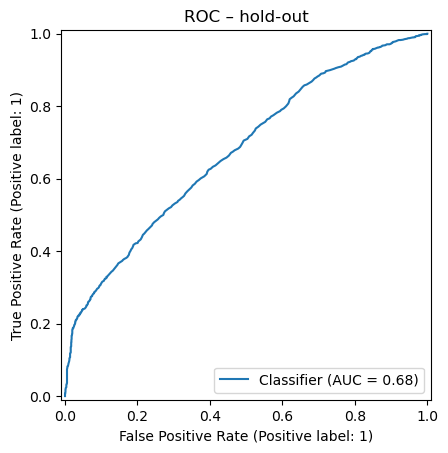

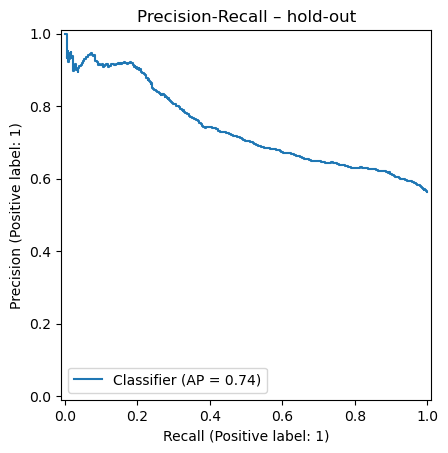

In [14]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, shuffle=False)
best_pipe.fit(X_train, y_train)
prob = best_pipe.predict_proba(X_hold)[:,1]

RocCurveDisplay.from_predictions(y_hold, prob)
plt.title('ROC – hold-out'); plt.show()

PrecisionRecallDisplay.from_predictions(y_hold, prob)
plt.title('Precision-Recall – hold-out'); plt.show()

By combining difficulty features with user features the model improves significantly

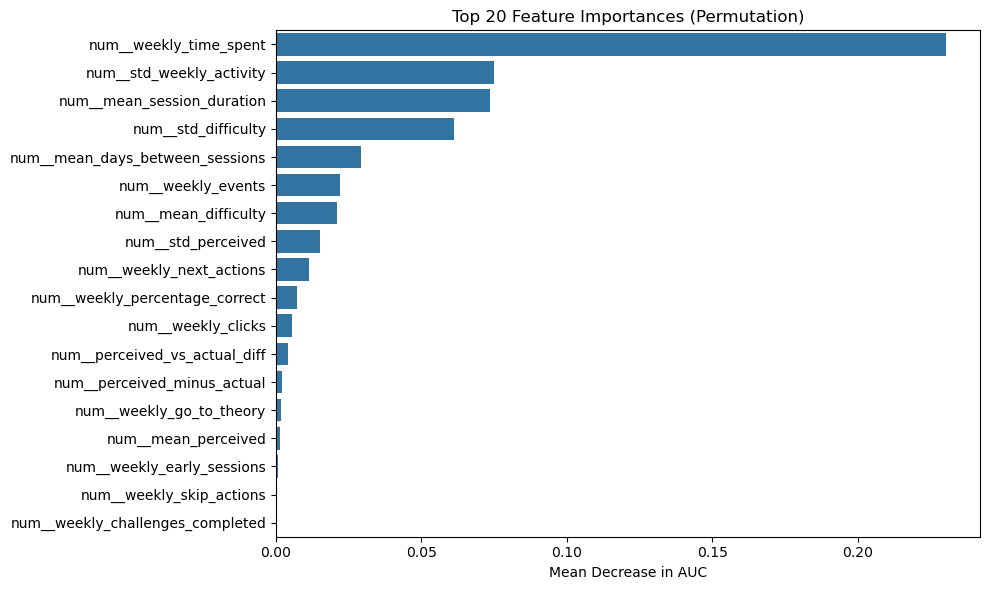

In [15]:
# Examine features importances in the model 

# Refit the best pipeline on full data
best_pipe.fit(X, y)

# Extract the final model step (last in pipeline)
final_model = best_pipe.steps[-1][1]  # grabs the actual model (e.g., RandomForestClassifier)
preprocessor = best_pipe.named_steps['columntransformer']

# Preprocess X
X_processed = preprocessor.transform(X)

# Run permutation importance
r = permutation_importance(final_model, X_processed, y, n_repeats=10, random_state=42, n_jobs=-1)

# Get feature names
feature_names = preprocessor.get_feature_names_out()
sorted_idx = r.importances_mean.argsort()[::-1]

# Plot top 20
plt.figure(figsize=(10, 6))
sns.barplot(x=r.importances_mean[sorted_idx][:20], y=feature_names[sorted_idx][:20])
plt.title("Top 20 Feature Importances (Permutation)")
plt.xlabel("Mean Decrease in AUC")
plt.tight_layout()
plt.show()


,user_id,year_week,dropout_risk,mean_perceived_difficulty,engaged_next_week
8176,394927,2022-18,1.000,0.821833,1
6014,394680,2021-36,1.000,NaN,1
20618,410825,2022-33,0.998,0.234391,1
7278,394804,2021-42,0.998,-0.252541,1
7089,394776,2021-48,0.998,0.013743,1
8069,394922,2021-47,0.998,0.614222,1
8658,394975,2021-48,0.998,-0.224346,1
7052,394774,2022-13,0.998,-0.079689,1
8232,394952,2021-49,0.998,0.046213,1
8446,394963,2021-49,0.996,0.356074,1


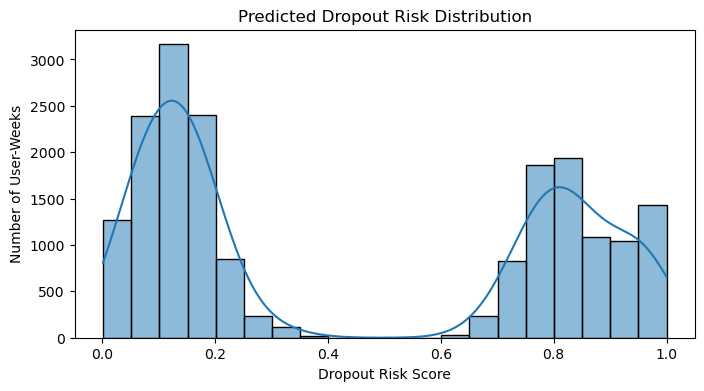

In [16]:
# Predict risk (probability of disengagement)
risk_scores = best_pipe.predict_proba(X)[:, 1]

# Add to original user-week dataframe
dashboard = df_model.copy()
dashboard['dropout_risk'] = risk_scores
dashboard['engaged_next_week'] = y.values
dashboard['mean_perceived_difficulty'] = difficulty.groupby(['user_id', 'year_week'])['perceived_difficulty'].mean().reset_index(drop=True)

# Show top 10 most at-risk learners
top_risks = dashboard.sort_values(by='dropout_risk', ascending=False).head(10)
display(top_risks[['user_id', 'year_week', 'dropout_risk', 'mean_perceived_difficulty', 'engaged_next_week']])

plt.figure(figsize=(8, 4))
sns.histplot(dashboard['dropout_risk'], bins=20, kde=True)
plt.title("Predicted Dropout Risk Distribution")
plt.xlabel("Dropout Risk Score")
plt.ylabel("Number of User-Weeks")
plt.show()

/var/folders/3k/8x7fm481513gdjkp_dsyjf3m0000gn/T/ipykernel_14622/2846775705.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  difficulty_risk = dashboard.groupby('difficulty_bin')['dropout_risk'].mean().reset_index()


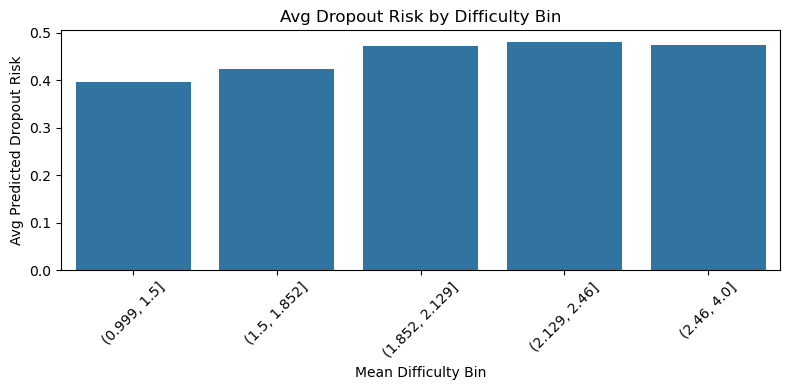

/var/folders/3k/8x7fm481513gdjkp_dsyjf3m0000gn/T/ipykernel_14622/2846775705.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perceived_risk = dashboard.groupby('perceived_bin')['dropout_risk'].mean().reset_index()


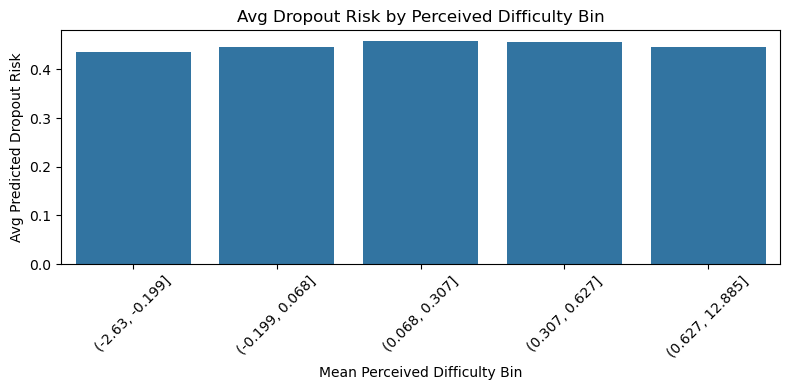

In [17]:
# Bin difficulty into quantiles
dashboard['difficulty_bin'] = pd.qcut(dashboard['mean_difficulty'], q=5)
difficulty_risk = dashboard.groupby('difficulty_bin')['dropout_risk'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x='difficulty_bin', y='dropout_risk', data=difficulty_risk)
plt.xticks(rotation=45)
plt.title("Avg Dropout Risk by Difficulty Bin")
plt.xlabel("Mean Difficulty Bin")
plt.ylabel("Avg Predicted Dropout Risk")
plt.tight_layout()
plt.show()

# Repeat for perceived difficulty
dashboard['perceived_bin'] = pd.qcut(dashboard['mean_perceived_difficulty'], q=5)
perceived_risk = dashboard.groupby('perceived_bin')['dropout_risk'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x='perceived_bin', y='dropout_risk', data=perceived_risk)
plt.xticks(rotation=45)
plt.title("Avg Dropout Risk by Perceived Difficulty Bin")
plt.xlabel("Mean Perceived Difficulty Bin")
plt.ylabel("Avg Predicted Dropout Risk")
plt.tight_layout()
plt.show()


### Evaluate difficulty impact on weekly time spent

In [18]:
y = df_model['weekly_time_spent']  # Target

difficulty_features = [
    'mean_difficulty', 'std_difficulty',
    'mean_perceived', 'std_perceived',
    'perceived_vs_actual_diff'
]
X = df_model[difficulty_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)  # no shuffle due to time dependency

numeric_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), difficulty_features)
])

MODELS = {
    'Linear'       : LinearRegression(),
    'RandomForest' : RandomForestRegressor(n_estimators=300, random_state=42)
}

results = []

for name, reg in MODELS.items():
    pipe = make_pipeline(numeric_preprocessor, reg)
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    results.append({'model': name, 'R2': r2, 'RMSE': rmse})

results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
display(results_df)


/Users/valentine/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/valentine/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,R2,RMSE
0,Linear,-0.047946,2.401356e+06
1,RandomForest,-0.247583,2.620124e+06


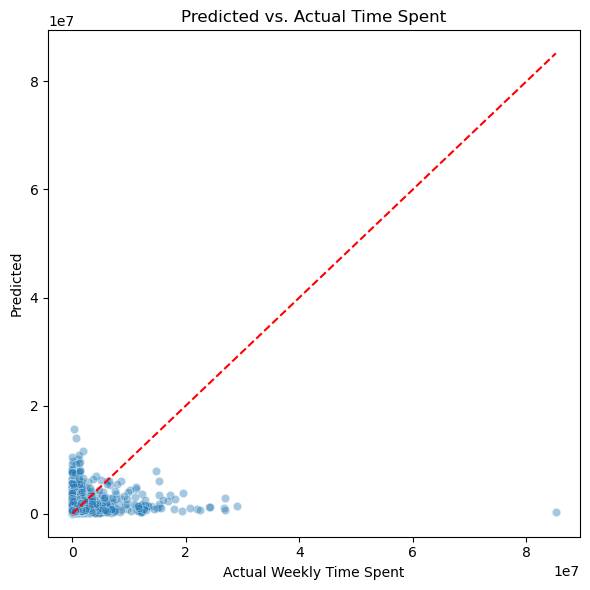

In [19]:
best_pipe = make_pipeline(numeric_preprocessor, RandomForestRegressor(n_estimators=300, random_state=42))
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Weekly Time Spent")
plt.ylabel("Predicted")
plt.title("Predicted vs. Actual Time Spent")
plt.tight_layout()
plt.show()

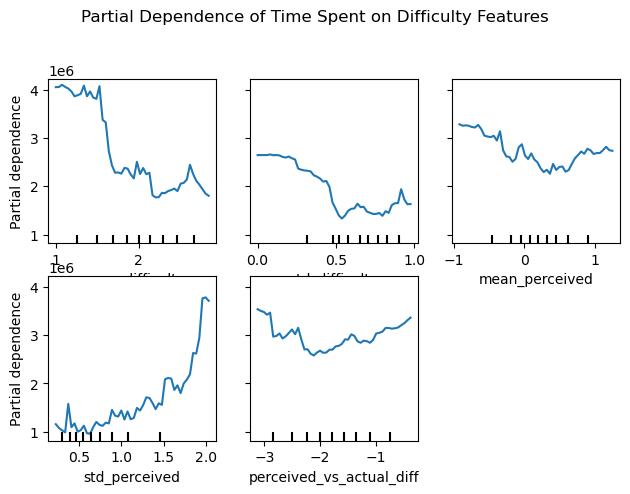

In [20]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(best_pipe, X, features=difficulty_features, grid_resolution=50)
plt.suptitle("Partial Dependence of Time Spent on Difficulty Features", y=1.02)
plt.tight_layout()
plt.show()

In [23]:
# Features and target
features = [
    'mean_difficulty', 'std_difficulty',
    'mean_perceived', 'std_perceived',
    'perceived_vs_actual_diff',
]
X = df_model[features]
y = df_model['weekly_time_spent']

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), features)
])

# Models
MODELS = {
    'Ridge' : Ridge(alpha=1.0),
    'Lasso' : Lasso(alpha=0.1),
}

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
results = []

for name, model in MODELS.items():
    r2s, rmses = [], []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipe = make_pipeline(preprocessor, model)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        r2s.append(r2_score(y_test, y_pred))
        rmses.append(mean_squared_error(y_test, y_pred, squared=False))

    results.append({
        'model': name,
        'R2_mean': np.mean(r2s),
        'RMSE_mean': np.mean(rmses)
    })

# Display results
results_df = pd.DataFrame(results).sort_values(by='R2_mean', ascending=False)
display(results_df)


/Users/valentine/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/valentine/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/valentine/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/valentine/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in ve

,model,R2_mean,RMSE_mean
0,Ridge,0.003307,3.366584e+06
1,Lasso,0.003305,3.366587e+06


## Separate Math & German

### Preprocessing

In [24]:
df_model.head()

,user_id,year_week,weekly_events,weekly_clicks,weekly_time_spent,mean_session_duration,mean_days_between_sessions,weekly_go_to_theory,weekly_early_sessions,weekly_next_actions,...,std_weekly_activity,week_start,week_period,engaged_next_week,mean_difficulty,std_difficulty,mean_perceived,std_perceived,perceived_minus_actual,perceived_vs_actual_diff
0,387604,2021-26,25,12.0,1.047106e+07,2.957527e+07,9.000000,0.0,0.0,0.0,...,141.95107,2021-06-27,2021-06-21/2021-06-27,0,2.625000,0.916125,-0.924275,2.234117,-0.924275,-3.549275
3,387604,2021-35,405,111.0,8.352444e+04,6.424957e+03,0.846154,118.0,3.0,0.0,...,141.95107,2021-08-29,2021-08-23/2021-08-29,1,2.000000,0.000000,-1.965535,0.500779,-1.965535,-3.965535
6,387604,2021-38,151,43.0,1.185300e+01,2.963250e+00,2.750000,14.0,0.0,0.0,...,141.95107,2021-09-19,2021-09-13/2021-09-19,1,1.833333,0.408248,-0.881810,0.274496,-0.881810,-2.715144
7,387604,2021-39,23,2.0,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,...,141.95107,2021-09-26,2021-09-20/2021-09-26,1,2.500000,1.000000,-0.452318,0.179803,-0.452318,-2.952318
10,387604,2021-44,249,45.0,1.910434e+07,5.423800e+01,20.000000,0.0,0.0,6.0,...,141.95107,2021-10-31,2021-10-25/2021-10-31,1,2.703704,1.102962,-1.103799,1.317934,-1.103799,-3.807503


In [25]:
topics = pd.read_csv('/Users/valentine/mlbd-2025/project/Lernnavi/Lernnavi_Data/topics_translated.csv')

In [26]:
topic_difficulty = difficulty.merge(
    topics[['id', 'math']],
    left_on='topic_id_x',
    right_on='id',
    how='left'
).drop(columns=['id'])

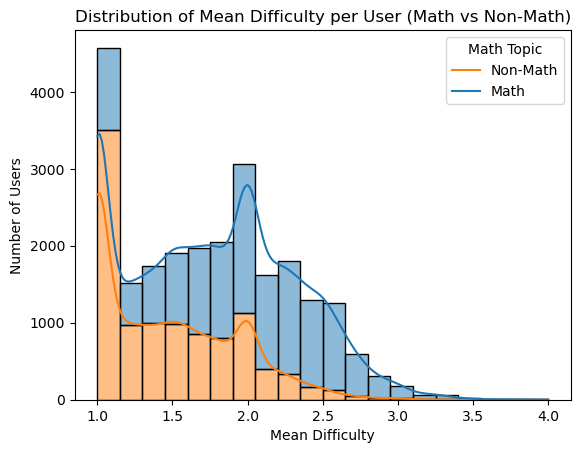

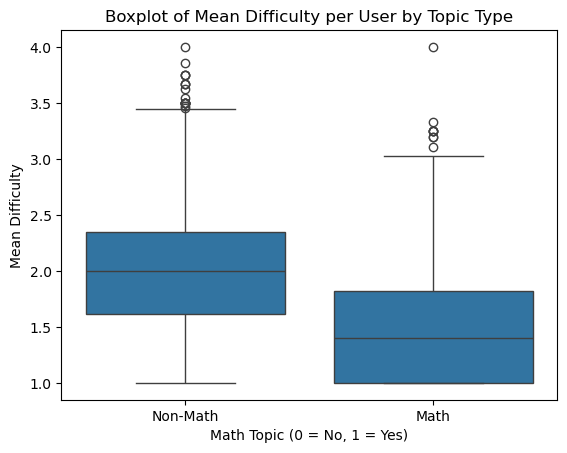

In [27]:
# Observe distribution of question difficulty 

# Mean difficulty
mean_diff = topic_difficulty.groupby(['user_id', 'year_week', 'math'])['difficulty'].mean().reset_index(name='mean_difficulty')

# Count of each difficulty
counts = pd.pivot_table(
    topic_difficulty,
    index=['user_id', 'year_week', 'math'],
    columns='difficulty',
    aggfunc='size',
    fill_value=0
).reset_index()

# Rename columns
counts.columns.name = None
counts = counts.rename(columns={
    1: 'difficulty_1_count',
    2: 'difficulty_2_count',
    3: 'difficulty_3_count',
    4: 'difficulty_4_count'
})

# Merge
weekly_difficulty = pd.merge(mean_diff, counts, on=['user_id', 'year_week', 'math'])
user_mean_difficulty = weekly_difficulty.groupby(['user_id', 'math'])['mean_difficulty'].mean().reset_index()

sns.histplot(data=user_mean_difficulty, x='mean_difficulty', hue='math', bins=20, kde=True, multiple='stack')
plt.title('Distribution of Mean Difficulty per User (Math vs Non-Math)')
plt.xlabel('Mean Difficulty')
plt.ylabel('Number of Users')
plt.legend(title='Math Topic', labels=['Non-Math', 'Math'])
plt.show()

sns.boxplot(data=user_mean_difficulty, x='math', y='mean_difficulty')
plt.title('Boxplot of Mean Difficulty per User by Topic Type')
plt.xlabel('Math Topic (0 = No, 1 = Yes)')
plt.ylabel('Mean Difficulty')
plt.xticks([0, 1], ['Non-Math', 'Math'])
plt.show()


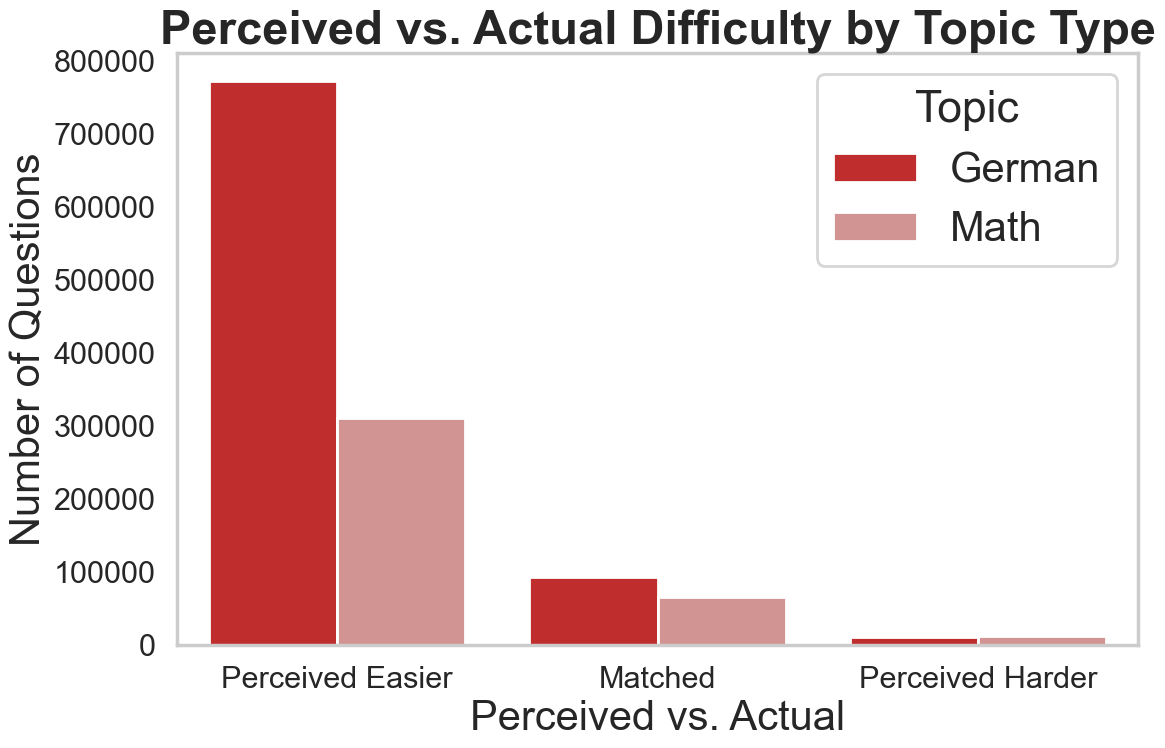

In [111]:
# Show perceived vs actual difficulty

threshold = 0.5

topic_difficulty['perceived_vs_actual'] = topic_difficulty.apply(
    lambda row: -1 if row['perceived_difficulty'] < row['difficulty'] - threshold
    else (1 if row['perceived_difficulty'] > row['difficulty'] + threshold 
    else 0),
    axis=1
)

# Create label names for readability
label_map = {-1: 'Perceived Easier', 0: 'Matched', 1: 'Perceived Harder'}
topic_difficulty['perceived_label'] = topic_difficulty['perceived_vs_actual'].map(label_map)

# Set global style and font scale
sns.set(style='whitegrid')
sns.set_context("poster")

# Plot
plt.figure(figsize=(12, 8))
sns.countplot(
    data=topic_difficulty,
    x='perceived_label',
    hue='math',
    order=['Perceived Easier', 'Matched', 'Perceived Harder'],
    palette=['#D81515FF', '#DD8888']
)

# Titles and labels
plt.title('Perceived vs. Actual Difficulty by Topic Type', fontsize=34, weight='bold')
plt.xlabel('Perceived vs. Actual', fontsize=30)
plt.ylabel('Number of Questions', fontsize=30)

# Legend
plt.legend(title='Topic', labels=['German', 'Math'], fontsize=30, title_fontsize=32)

# Grid
plt.grid(False)

plt.savefig("student_engagement_poster.png", dpi=300, bbox_inches='tight', transparent=True)

# Layout
plt.tight_layout()
plt.show()


In [29]:
# Aggregate actual and perceived difficulty per user-week
weekly_difficulty_stats = topic_difficulty.groupby(['user_id', 'year_week', 'math']).agg(
    mean_difficulty=('difficulty', 'mean'),
    std_difficulty=('difficulty', 'std'),
    mean_perceived=('perceived_difficulty', 'mean'),
    std_perceived=('perceived_difficulty', 'std'),
    perceived_minus_actual=('perceived_difficulty', lambda x: x.mean())  # we'll subtract later
).reset_index()

# Add perceived - actual difference
weekly_difficulty_stats['perceived_vs_actual_diff'] = (
    weekly_difficulty_stats['mean_perceived'] - weekly_difficulty_stats['mean_difficulty']
)

df_model = pd.merge(user_week_features, weekly_difficulty_stats, on=['user_id', 'year_week'], how='left').dropna()

# Define features and target
features = [
    'mean_difficulty',
    'std_difficulty',
    'mean_perceived',
    'std_perceived',
    'perceived_vs_actual_diff'
]

#### Difficulty features only

In [ ]:
df_math     = df_model[df_model['math'] == 1].copy()
df_german = df_model[df_model['math'] == 0].copy()

def cross_val(pipe, X, y, cv):
    aucs, f1s = [], []
    for tr, te in cv.split(X):
        pipe.fit(X.iloc[tr], y.iloc[tr])
        p = pipe.predict_proba(X.iloc[te])[:, 1]
        yhat = (p >= 0.5).astype(int)
        aucs.append(roc_auc_score(y.iloc[te], p))
        f1s.append(f1_score(y.iloc[te], yhat))
    return np.mean(aucs), np.mean(f1s)

def run_modeling_pipeline(df_subset, name=''):
    X = df_subset[features]
    y = df_subset['engaged_next_week']
    
    tscv = TimeSeriesSplit(n_splits=5)
    rows = []

    numeric_cols = X.select_dtypes(include='number').columns

    pre = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
    ])

    for model_name, clf in MODELS.items():
        pipe = make_pipeline(pre, clf)
        auc2, f12 = cross_val(pipe, X, y, tscv)
        rows.append({'model': model_name, 'AUC': auc2, 'F1': f12})

    leader = pd.DataFrame(rows).sort_values('AUC', ascending=False).reset_index(drop=True)
    display(leader.style.background_gradient(cmap='viridis', subset=['AUC', 'F1']))
    
    best = leader.iloc[0]
    print(f"\nBest for {name}: {best['model']} AUC={best['AUC']:.3f}")
    
    # Fit on full train and evaluate on hold-out
    X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, shuffle=False)
    final_pipe = make_pipeline(pre, MODELS[best['model']])
    final_pipe.fit(X_train, y_train)
    prob = final_pipe.predict_proba(X_hold)[:, 1]
    
    # Plot ROC
    fig, ax = plt.subplots(figsize=(10, 8))
    RocCurveDisplay.from_predictions(
        y_hold, prob, name=name,
        ax=ax, color=f'#D81515FF', linewidth=3
    )

    ax.set_title(f'ROC Curve – Hold-out ({name})', fontsize=30, weight='bold')
    ax.set_xlabel('False Positive Rate', fontsize=24)
    ax.set_ylabel('True Positive Rate', fontsize=24)
    ax.tick_params(axis='both', labelsize=18)
    ax.legend(fontsize=20, title_fontsize=22)

    plt.tight_layout()
    plt.savefig(f"roc_curve_{name.lower()}.png", dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

MODELS = {
    'Dummy'        : DummyClassifier(strategy='most_frequent'),
    'Logistic'     : LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest' : RandomForestClassifier(n_estimators=600, class_weight='balanced', random_state=42),
    'GradientBoost': GradientBoostingClassifier(random_state=42)
}

,model,AUC,F1
0,RandomForest,0.539835,0.466928
1,GradientBoost,0.539731,0.455138
2,Logistic,0.535804,0.518672
3,Dummy,0.500000,0.000000



Best for German: RandomForest AUC=0.540


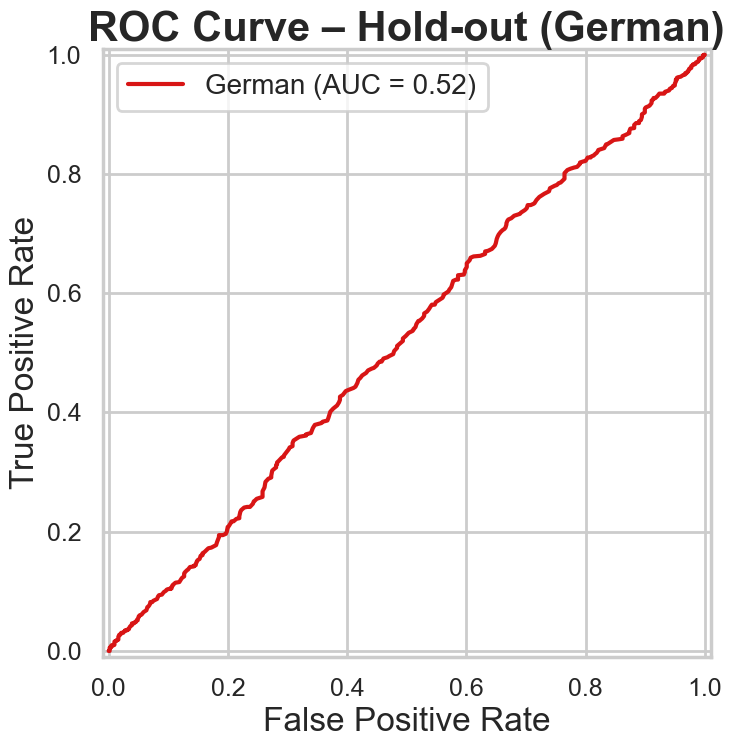

In [119]:
#run_modeling_pipeline(df_math, name='Math')
run_modeling_pipeline(df_german, name='German')
#German_color = '#D81515FF'

### Difficulty + behavioral features

In [32]:
def run_full_pipeline(df, name="All"):
    print(f"\n====== Modeling: {name} ======\n")

    # Drop ID columns
    X = df.drop(columns=['user_id', 'year_week', 'engaged_next_week'])
    y = df['engaged_next_week']

    # Select only numeric features
    numeric_cols = X.select_dtypes(include='number').columns
    pre = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
    ])

    # TimeSeries CV
    tscv = TimeSeriesSplit(n_splits=5)
    
    results = []
    best_auc = -np.inf
    best_pipe = None
    best_model_name = None

    for name_model, clf in MODELS.items():
        pipe = make_pipeline(pre, clf)
        auc, f1 = cross_val(pipe, X, y, tscv)
        results.append({'model': name_model, 'AUC': auc, 'F1': f1})
        if auc > best_auc:
            best_auc = auc
            best_pipe = pipe
            best_model_name = name_model

    # Leaderboard
    leaderboard = pd.DataFrame(results).sort_values('AUC', ascending=False).reset_index(drop=True)
    display(leaderboard.style.background_gradient(cmap='YlGnBu', subset=['AUC', 'F1']))

    # Train on holdout
    X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, shuffle=False)
    best_pipe.fit(X_train, y_train)
    prob = best_pipe.predict_proba(X_hold)[:, 1]

    RocCurveDisplay.from_predictions(y_hold, prob)
    plt.title(f'ROC – hold-out ({name})')
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_hold, prob)
    plt.title(f'Precision-Recall – hold-out ({name})')
    plt.show()

    # Permutation importance
    best_pipe.fit(X, y)
    final_model = best_pipe.steps[-1][1]
    preprocessor = best_pipe.named_steps['columntransformer']
    X_processed = preprocessor.transform(X)

    r = permutation_importance(final_model, X_processed, y, n_repeats=10, random_state=42, n_jobs=-1)
    feature_names = preprocessor.get_feature_names_out()
    sorted_idx = r.importances_mean.argsort()[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=r.importances_mean[sorted_idx][:20], y=feature_names[sorted_idx][:20])
    plt.title(f"Top 20 Feature Importances (Permutation) – {name}")
    plt.xlabel("Mean Decrease in AUC")
    plt.tight_layout()
    plt.show()

    return leaderboard, pd.DataFrame({
    'feature': feature_names[sorted_idx],
    'importance': r.importances_mean[sorted_idx]
}), best_pipe



====== Modeling: Math ======



,model,AUC,F1
0,RandomForest,0.772578,0.624557
1,GradientBoost,0.772446,0.614406
2,Logistic,0.619972,0.574018
3,Dummy,0.500000,0.000000


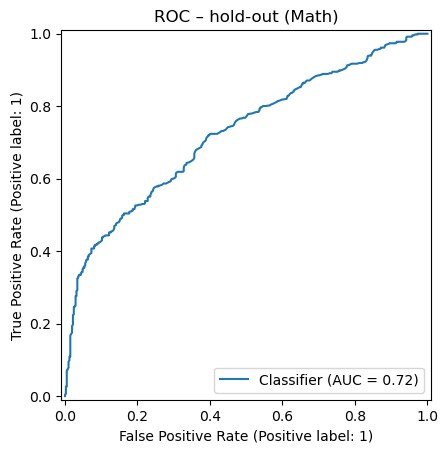

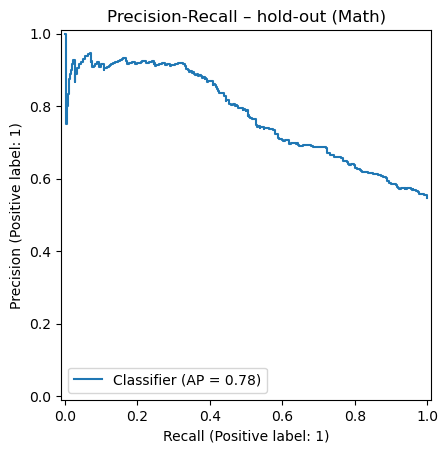

python(15726) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15727) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15728) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15729) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15730) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15731) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15732) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15733) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


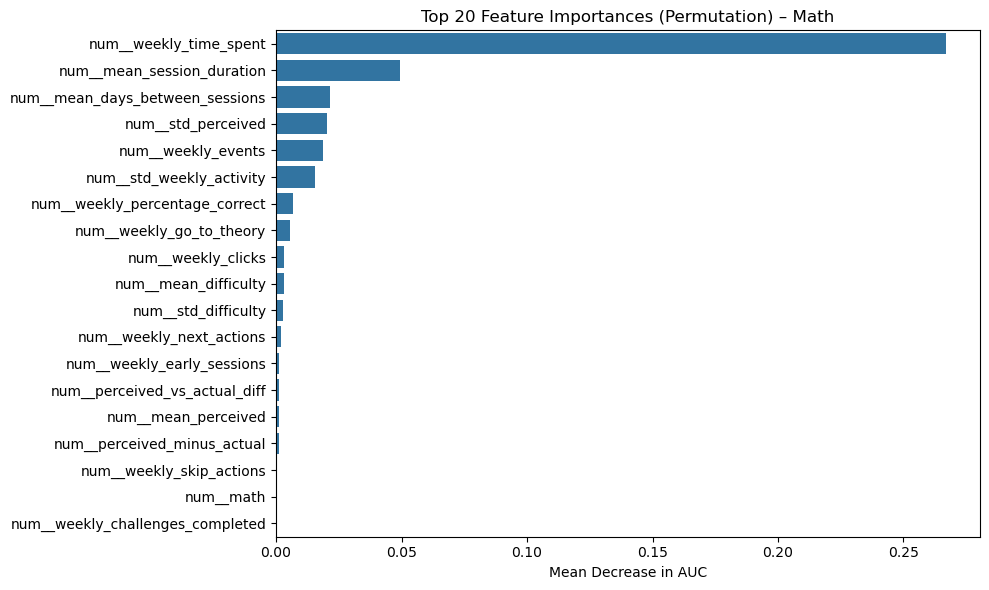


====== Modeling: German ======



,model,AUC,F1
0,GradientBoost,0.769186,0.655330
1,RandomForest,0.767029,0.660458
2,Logistic,0.610608,0.631413
3,Dummy,0.500000,0.000000


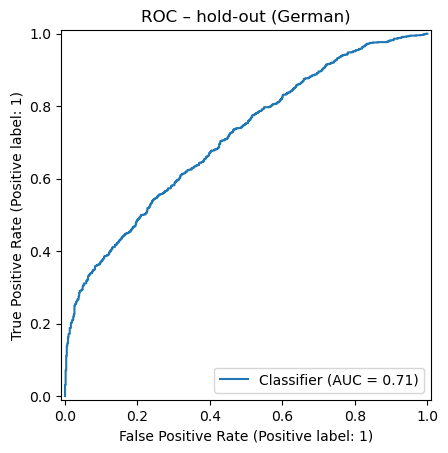

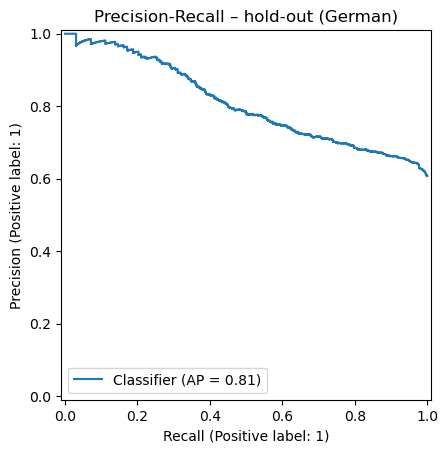

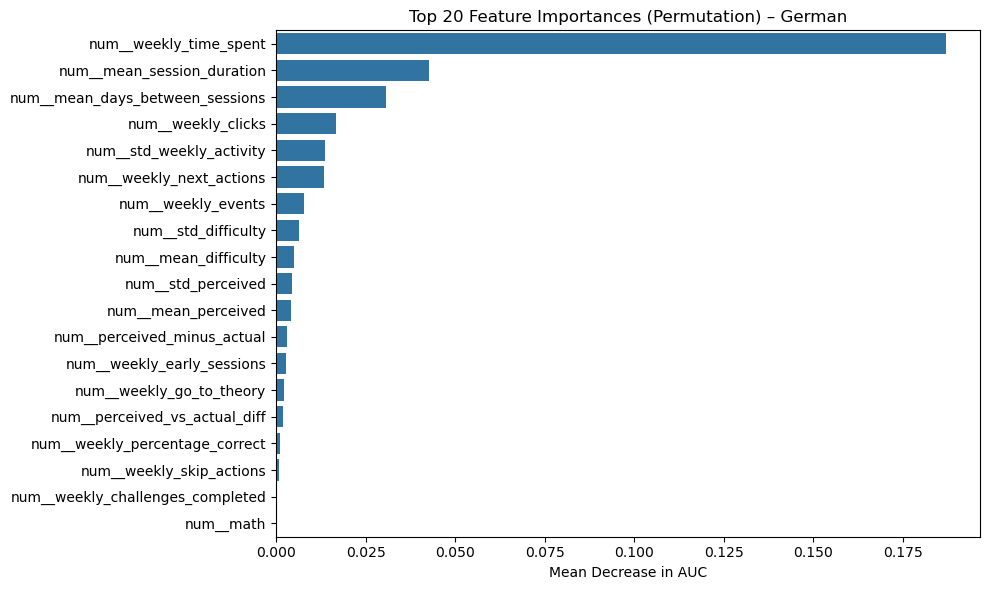

In [33]:
leader_math, feat_imp_math, best_pipe_math = run_full_pipeline(df_math, name='Math')
leader_german, feat_imp_german, best_pipe_german = run_full_pipeline(df_german, name='German')

/var/folders/3k/8x7fm481513gdjkp_dsyjf3m0000gn/T/ipykernel_14622/2974804480.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


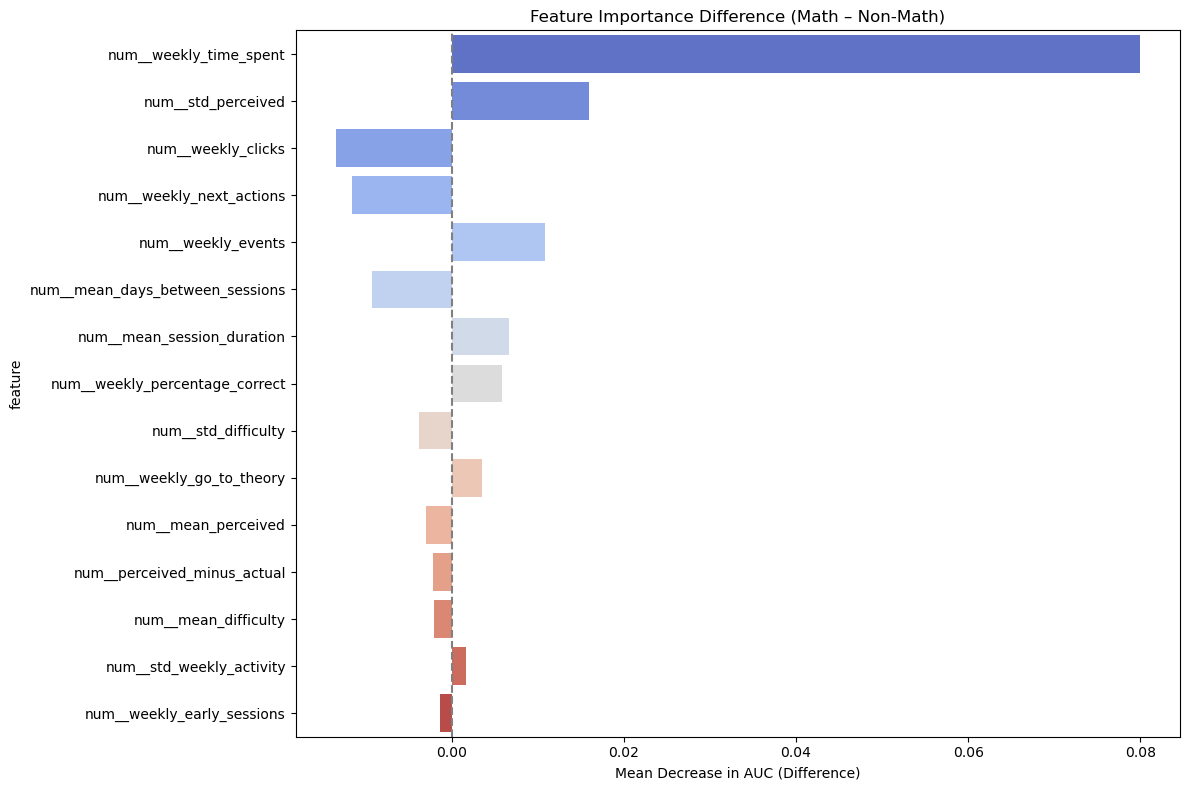

In [34]:
# Merge feature importance
fi_compare = pd.merge(feat_imp_math, feat_imp_german, on='feature', how='outer', suffixes=('_math', '_nonmath'))

# Compute difference
fi_compare['importance_diff'] = fi_compare['importance_math'] - fi_compare['importance_nonmath']
fi_compare = fi_compare.sort_values('importance_diff', key=abs, ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=fi_compare.head(15),
    y='feature',
    x='importance_diff',
    palette='coolwarm',
    orient='h'
)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Feature Importance Difference (Math – Non-Math)")
plt.xlabel("Mean Decrease in AUC (Difference)")
plt.tight_layout()
plt.show()


In [ ]:
def plot_side_by_side_feature_importances(fi_math, fi_nonmath, top_n=15):
    """
    Plot side-by-side barplot of permutation feature importances for Math and Non-Math groups,
    with poster-ready styling.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Copy data to avoid mutation
    fi_math = fi_math.copy()
    fi_nonmath = fi_nonmath.copy()

    # Add group labels
    fi_math['group'] = 'Math'
    fi_nonmath['group'] = 'German'

    # Combine and find top features by average importance
    fi_combined = pd.concat([fi_math, fi_nonmath], ignore_index=True)
    top_features = (
        fi_combined.groupby('feature')['importance']
        .mean()
        .sort_values(ascending=False)
        .head(top_n)
        .index
    )
    fi_top = fi_combined[fi_combined['feature'].isin(top_features)]
    fi_top['feature'] = fi_top['feature'].str.replace('^num__', '', regex=True)


    # Set Seaborn style for poster readability
    sns.set(style='whitegrid', context='poster')

    # Create plot
    plt.figure(figsize=(18, 12))  # Wider plot
    barplot = sns.barplot(
        data=fi_top,
        y='feature',
        x='importance',
        hue='group',
        palette=['#D81515FF', '#DD8888'],  # Firebrick & DarkRed for high contrast
        dodge=True
    )

    # Adjust visual styles
    plt.title(f"Top {top_n} Feature Importances: Math vs. German", fontsize=34, weight='bold')
    plt.xlabel("Mean Decrease in AUC (Permutation Importance)", fontsize=30)
    plt.ylabel("Feature", fontsize=30)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)
    plt.legend(title='Group', title_fontsize=32, fontsize=30)
    barplot.set_xlim(left=0)  # Ensure bars start from 0

    plt.savefig("student_engagement_poster.png", dpi=300, bbox_inches='tight', transparent=True)

    plt.tight_layout()
    plt.show()



/var/folders/3k/8x7fm481513gdjkp_dsyjf3m0000gn/T/ipykernel_14622/3621246548.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_top['feature'] = fi_top['feature'].str.replace('^num__', '', regex=True)


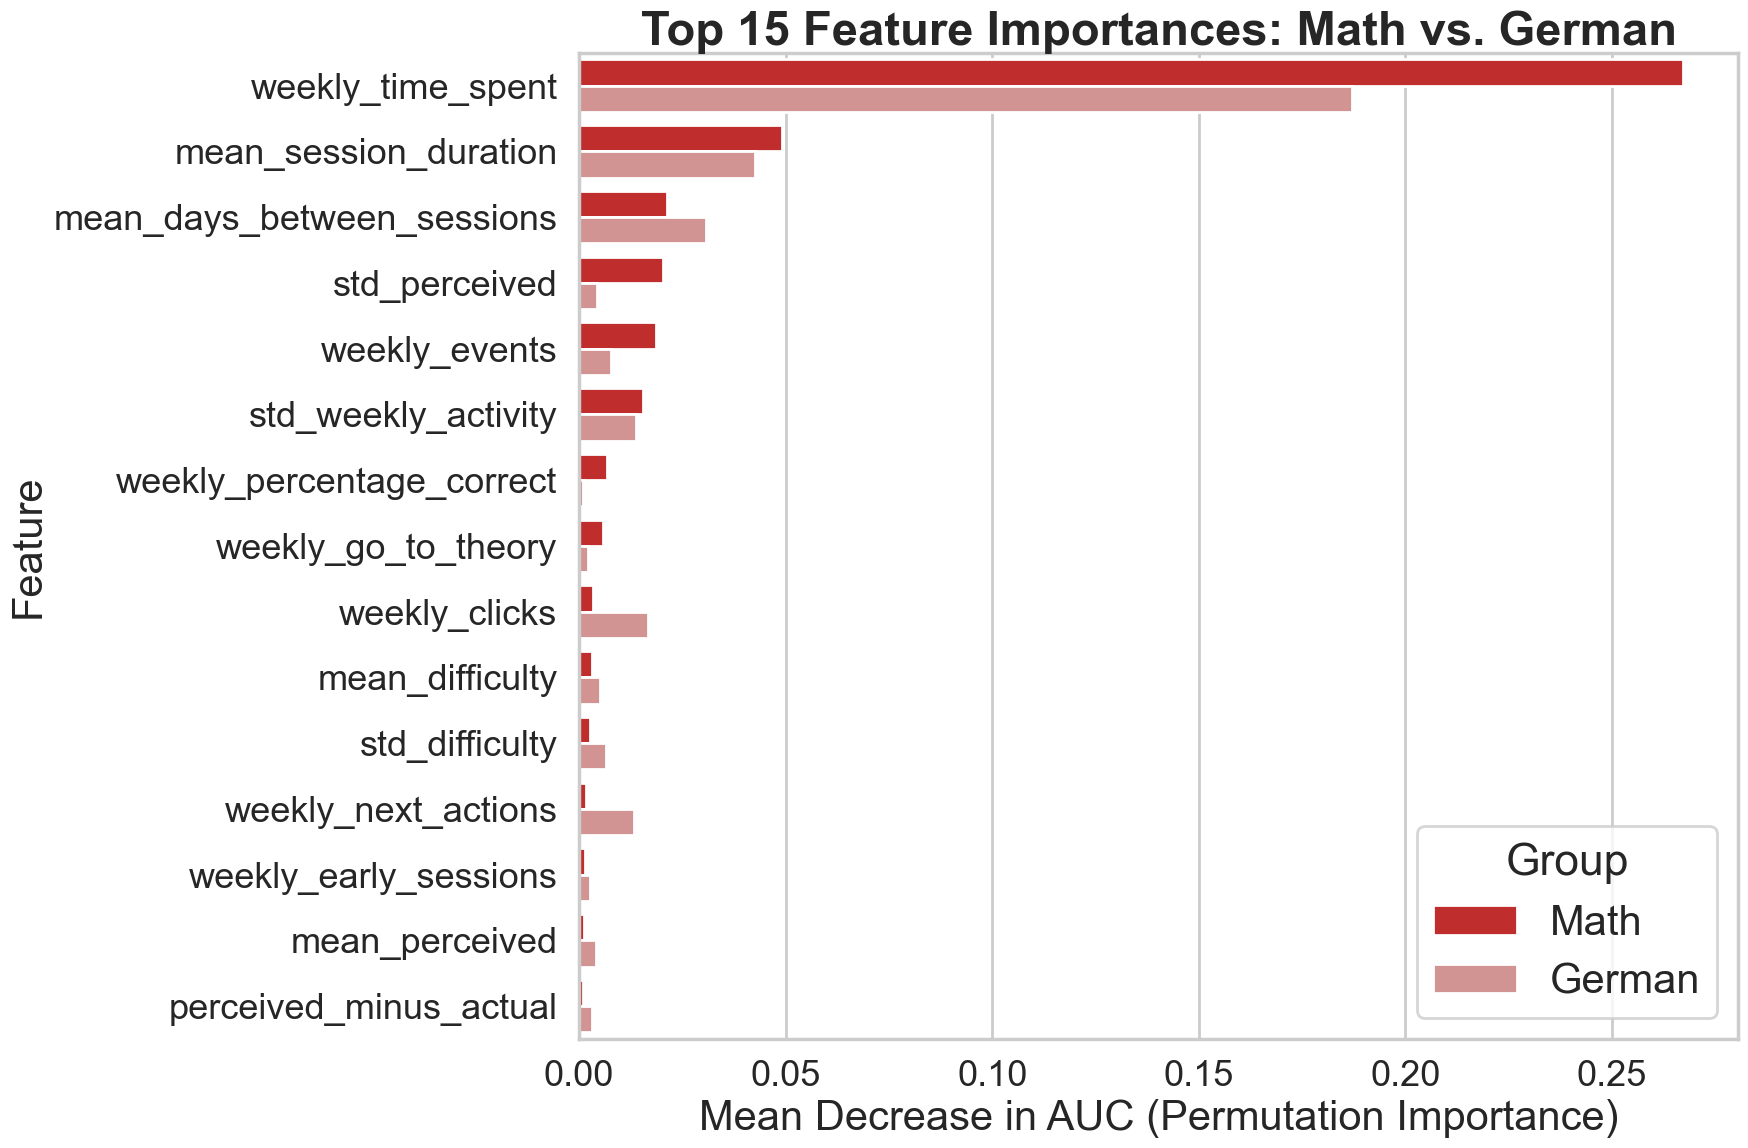

In [109]:
plot_side_by_side_feature_importances(feat_imp_math, feat_imp_german, top_n=15)


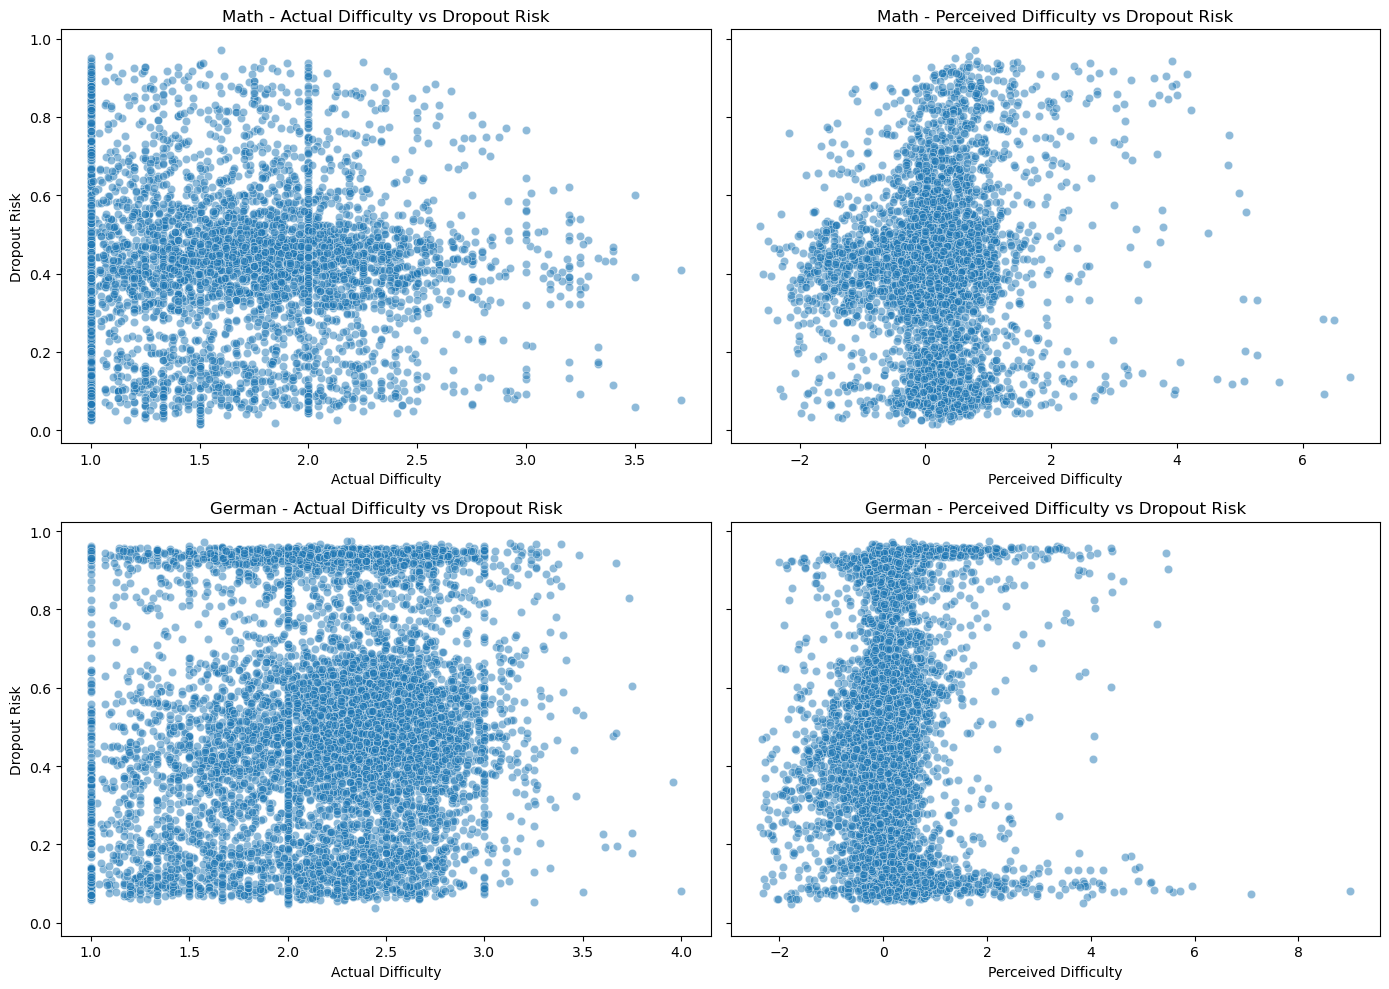

In [37]:
# Copy original dataframes (or subset used for modeling)
df_math_viz = df_math.copy()
df_german_viz = df_german.copy()

# Prepare features for prediction (drop IDs and target)
X_math = df_math_viz.drop(columns=['user_id', 'year_week', 'engaged_next_week'])
X_german = df_german_viz.drop(columns=['user_id', 'year_week', 'engaged_next_week'])

# Predict dropout risk using the best pipelines
df_math_viz['dropout_risk'] = best_pipe_math.predict_proba(X_math)[:, 1]
df_german_viz['dropout_risk'] = best_pipe_german.predict_proba(X_german)[:, 1]

# Add mean perceived difficulty from difficulty dataframe
mean_perceived = difficulty.groupby(['user_id', 'year_week'])['perceived_difficulty'].mean().reset_index()
df_math_viz = df_math_viz.merge(mean_perceived, on=['user_id', 'year_week'], how='left')
df_german_viz = df_german_viz.merge(mean_perceived, on=['user_id', 'year_week'], how='left')

# Add mean actual difficulty
mean_actual = difficulty.groupby(['user_id', 'year_week'])['difficulty'].mean().reset_index()
df_math_viz = df_math_viz.merge(mean_actual, on=['user_id', 'year_week'], how='left')
df_german_viz = df_german_viz.merge(mean_actual, on=['user_id', 'year_week'], how='left')

# Plotting side-by-side scatterplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

# Math - Actual Difficulty vs Dropout Risk
sns.scatterplot(
    data=df_math_viz,
    x='difficulty', y='dropout_risk',
    alpha=0.5, ax=axes[0, 0]
)
axes[0, 0].set_title('Math - Actual Difficulty vs Dropout Risk')
axes[0, 0].set_xlabel('Actual Difficulty')
axes[0, 0].set_ylabel('Dropout Risk')

# Math - Perceived Difficulty vs Dropout Risk
sns.scatterplot(
    data=df_math_viz,
    x='perceived_difficulty', y='dropout_risk',
    alpha=0.5, ax=axes[0, 1]
)
axes[0, 1].set_title('Math - Perceived Difficulty vs Dropout Risk')
axes[0, 1].set_xlabel('Perceived Difficulty')
axes[0, 1].set_ylabel('')

# German - Actual Difficulty vs Dropout Risk
sns.scatterplot(
    data=df_german_viz,
    x='difficulty', y='dropout_risk',
    alpha=0.5, ax=axes[1, 0]
)
axes[1, 0].set_title('German - Actual Difficulty vs Dropout Risk')
axes[1, 0].set_xlabel('Actual Difficulty')
axes[1, 0].set_ylabel('Dropout Risk')

# German - Perceived Difficulty vs Dropout Risk
sns.scatterplot(
    data=df_german_viz,
    x='perceived_difficulty', y='dropout_risk',
    alpha=0.5, ax=axes[1, 1]
)
axes[1, 1].set_title('German - Perceived Difficulty vs Dropout Risk')
axes[1, 1].set_xlabel('Perceived Difficulty')
axes[1, 1].set_ylabel('')

plt.tight_layout()
plt.show()


/var/folders/3k/8x7fm481513gdjkp_dsyjf3m0000gn/T/ipykernel_14622/1545180652.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby('diff_bin').agg(
/var/folders/3k/8x7fm481513gdjkp_dsyjf3m0000gn/T/ipykernel_14622/1545180652.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby('diff_bin').agg(
/var/folders/3k/8x7fm481513gdjkp_dsyjf3m0000gn/T/ipykernel_14622/1545180652.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default 

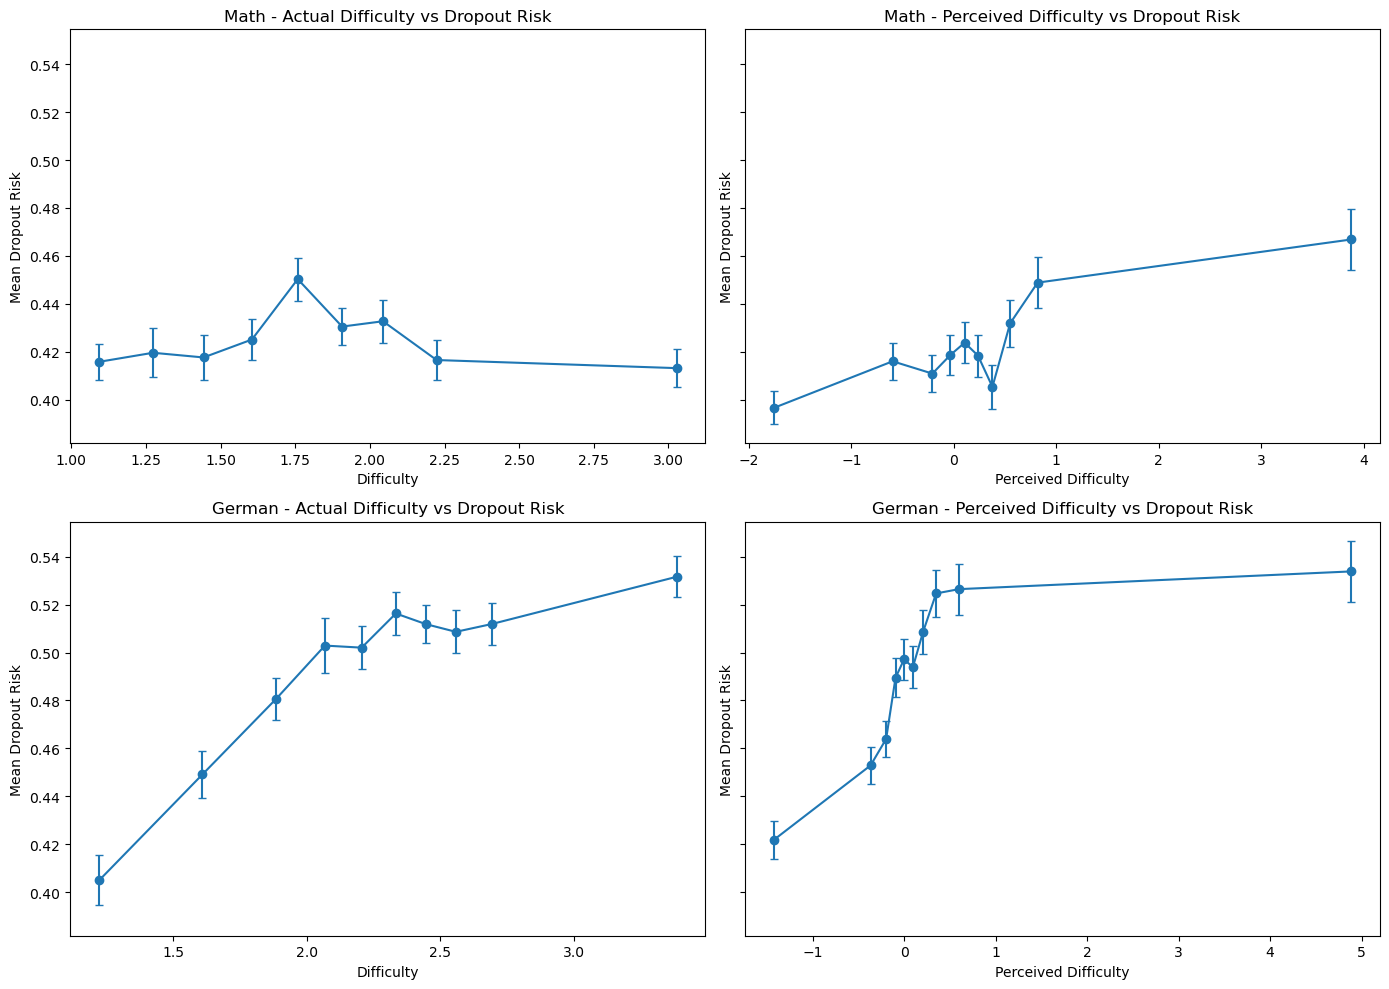

In [38]:
def plot_binned_risk(df, difficulty_col, ax, title):
    # Create bins (e.g., 10 bins)
    df['diff_bin'] = pd.qcut(df[difficulty_col], q=10, duplicates='drop')
    
    # Aggregate: mean dropout risk and std in each bin
    agg = df.groupby('diff_bin').agg(
        mean_risk=('dropout_risk', 'mean'),
        std_risk=('dropout_risk', 'std'),
        count=('dropout_risk', 'count')
    ).reset_index()
    
    # Use bin midpoints for plotting
    agg['bin_mid'] = agg['diff_bin'].apply(lambda x: x.mid)
    
    # Plot with error bars
    ax.errorbar(
        agg['bin_mid'], agg['mean_risk'],
        yerr=agg['std_risk'] / np.sqrt(agg['count']),  # standard error
        fmt='o-', capsize=3
    )
    ax.set_title(title)
    ax.set_xlabel(difficulty_col.replace('_', ' ').title())
    ax.set_ylabel('Mean Dropout Risk')

# Prepare the data as before
df_math_viz = df_math.copy()
df_german_viz = df_german.copy()

X_math = df_math_viz.drop(columns=['user_id', 'year_week', 'engaged_next_week'])
X_german = df_german_viz.drop(columns=['user_id', 'year_week', 'engaged_next_week'])

df_math_viz['dropout_risk'] = best_pipe_math.predict_proba(X_math)[:, 1]
df_german_viz['dropout_risk'] = best_pipe_german.predict_proba(X_german)[:, 1]

mean_perceived = difficulty.groupby(['user_id', 'year_week'])['perceived_difficulty'].mean().reset_index()
mean_actual = difficulty.groupby(['user_id', 'year_week'])['difficulty'].mean().reset_index()

df_math_viz = df_math_viz.merge(mean_perceived, on=['user_id', 'year_week'], how='left')
df_math_viz = df_math_viz.merge(mean_actual, on=['user_id', 'year_week'], how='left')

df_german_viz = df_german_viz.merge(mean_perceived, on=['user_id', 'year_week'], how='left')
df_german_viz = df_german_viz.merge(mean_actual, on=['user_id', 'year_week'], how='left')

# Plotting binned risk
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

plot_binned_risk(df_math_viz, 'difficulty', axes[0, 0], 'Math - Actual Difficulty vs Dropout Risk')
plot_binned_risk(df_math_viz, 'perceived_difficulty', axes[0, 1], 'Math - Perceived Difficulty vs Dropout Risk')
plot_binned_risk(df_german_viz, 'difficulty', axes[1, 0], 'German - Actual Difficulty vs Dropout Risk')
plot_binned_risk(df_german_viz, 'perceived_difficulty', axes[1, 1], 'German - Perceived Difficulty vs Dropout Risk')

plt.tight_layout()
plt.show()

### Difficulty evolution over time

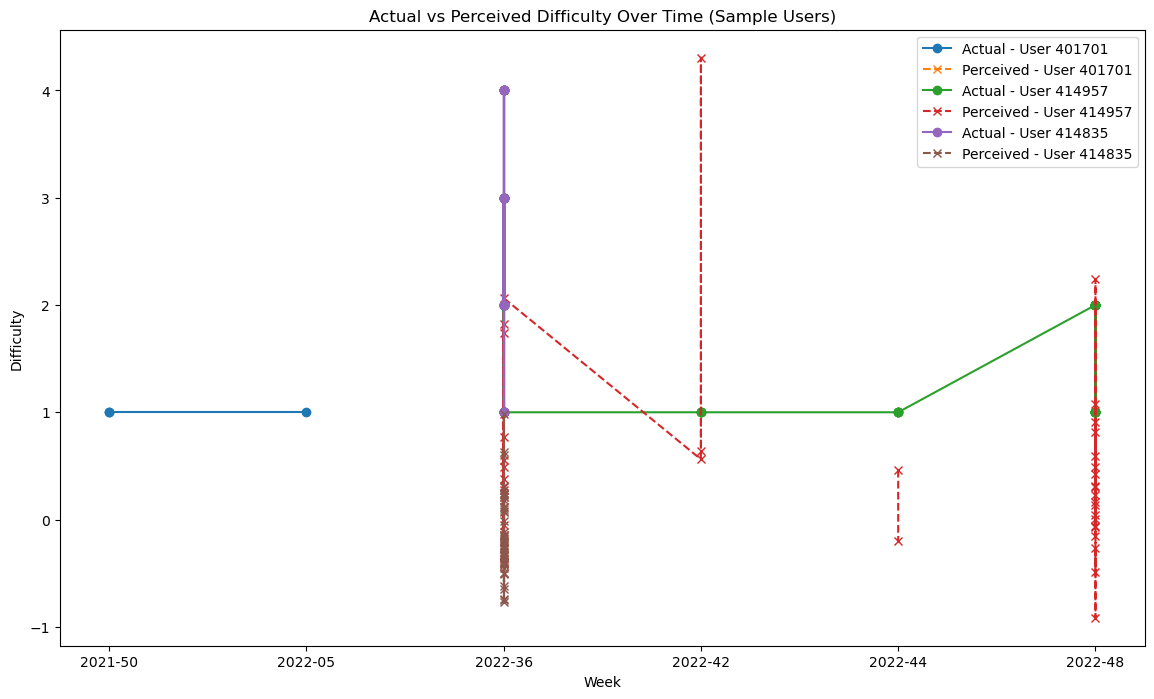

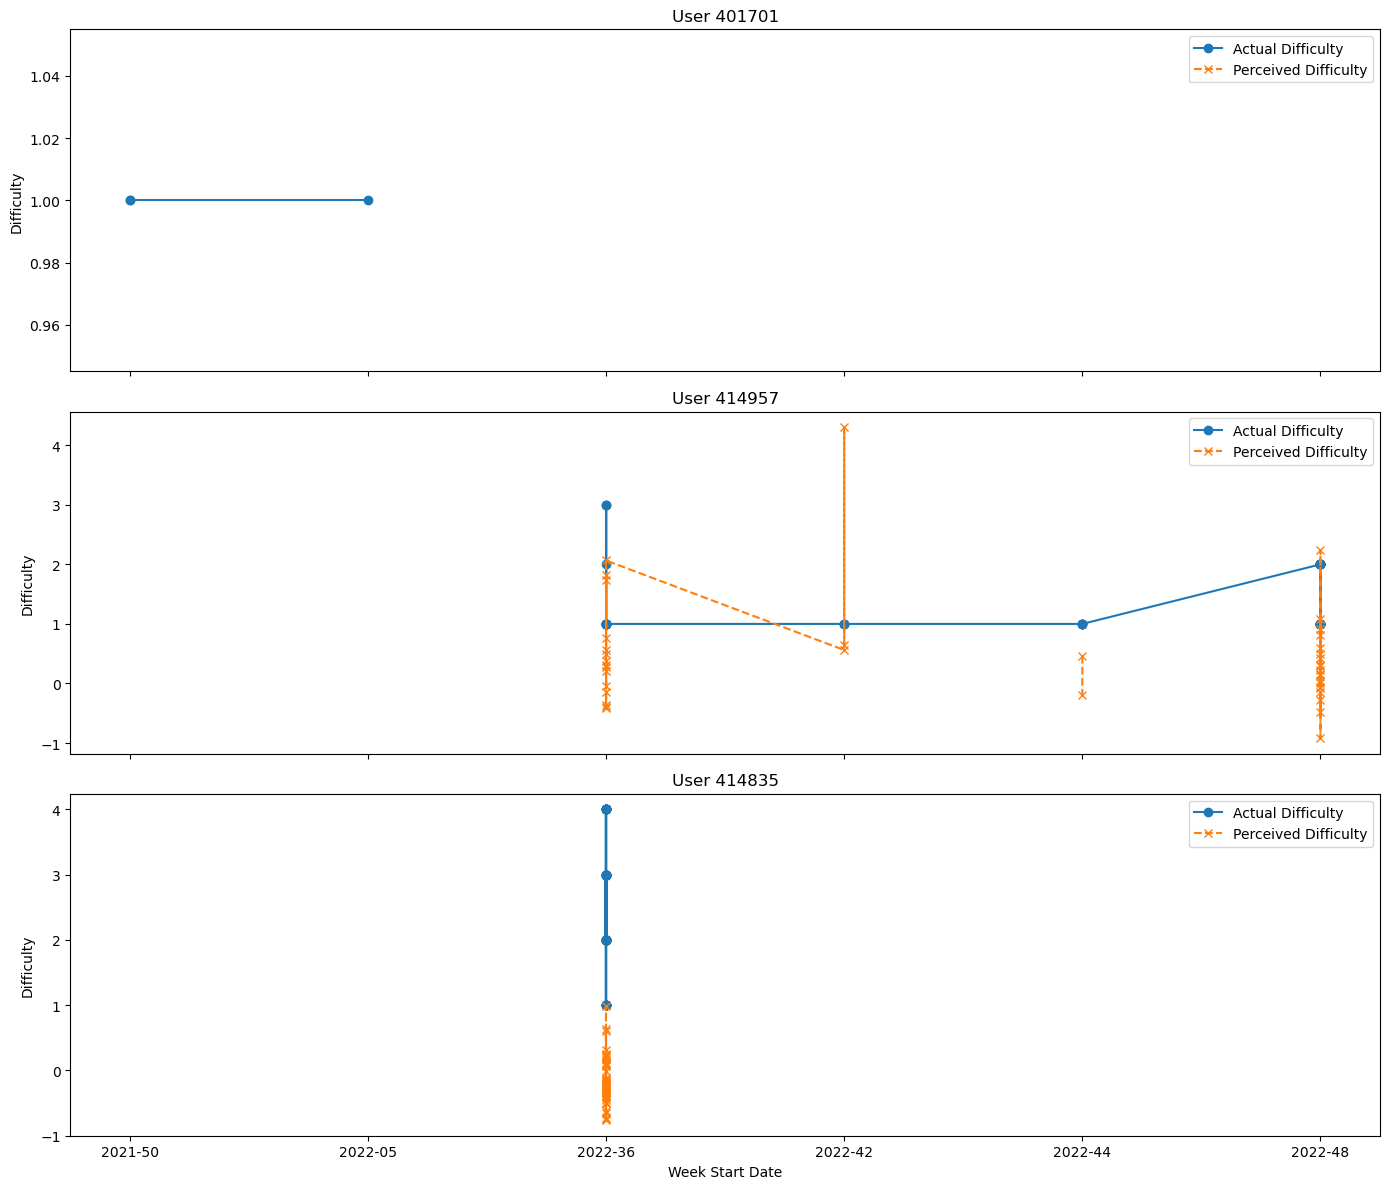

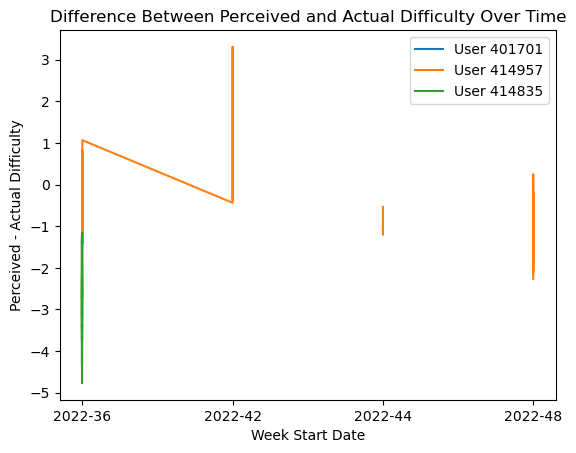

In [ ]:
# Sample 3 users
sample_users = topic_difficulty['user_id'].drop_duplicates().sample(3, random_state=42)

plt.figure(figsize=(14, 8))

for user in sample_users:
    user_data = topic_difficulty[topic_difficulty['user_id'] == user].sort_values('year_week')

    plt.plot(user_data['year_week'], user_data['difficulty'], label=f'Actual - User {user}', marker='o')
    plt.plot(user_data['year_week'], user_data['perceived_difficulty'], label=f'Perceived - User {user}', marker='x', linestyle='--')

plt.xlabel('Week')
plt.ylabel('Difficulty')
plt.title('Actual vs Perceived Difficulty Over Time (Sample Users)')
plt.legend()
plt.show()

users = sample_users.tolist()
fig, axes = plt.subplots(len(users), 1, figsize=(14, 4*len(users)), sharex=True)

for ax, user in zip(axes, users):
    user_data = topic_difficulty[topic_difficulty['user_id'] == user].sort_values('year_week')
    ax.plot(user_data['year_week'], user_data['difficulty'], label='Actual Difficulty', marker='o')
    ax.plot(user_data['year_week'], user_data['perceived_difficulty'], label='Perceived Difficulty', marker='x', linestyle='--')
    ax.set_title(f'User {user}')
    ax.set_ylabel('Difficulty')
    ax.legend()

plt.xlabel('Week Start Date')
plt.tight_layout()
plt.show()

topic_difficulty['diff_perceived_actual'] = topic_difficulty['perceived_difficulty'] - topic_difficulty['difficulty']

for user in sample_users:
    user_data = topic_difficulty[topic_difficulty['user_id'] == user].sort_values('year_week')
    plt.plot(user_data['year_week'], user_data['diff_perceived_actual'], label=f'User {user}')

plt.xlabel('Week Start Date')
plt.ylabel('Perceived - Actual Difficulty')
plt.title('Difference Between Perceived and Actual Difficulty Over Time')
plt.legend()
plt.show()

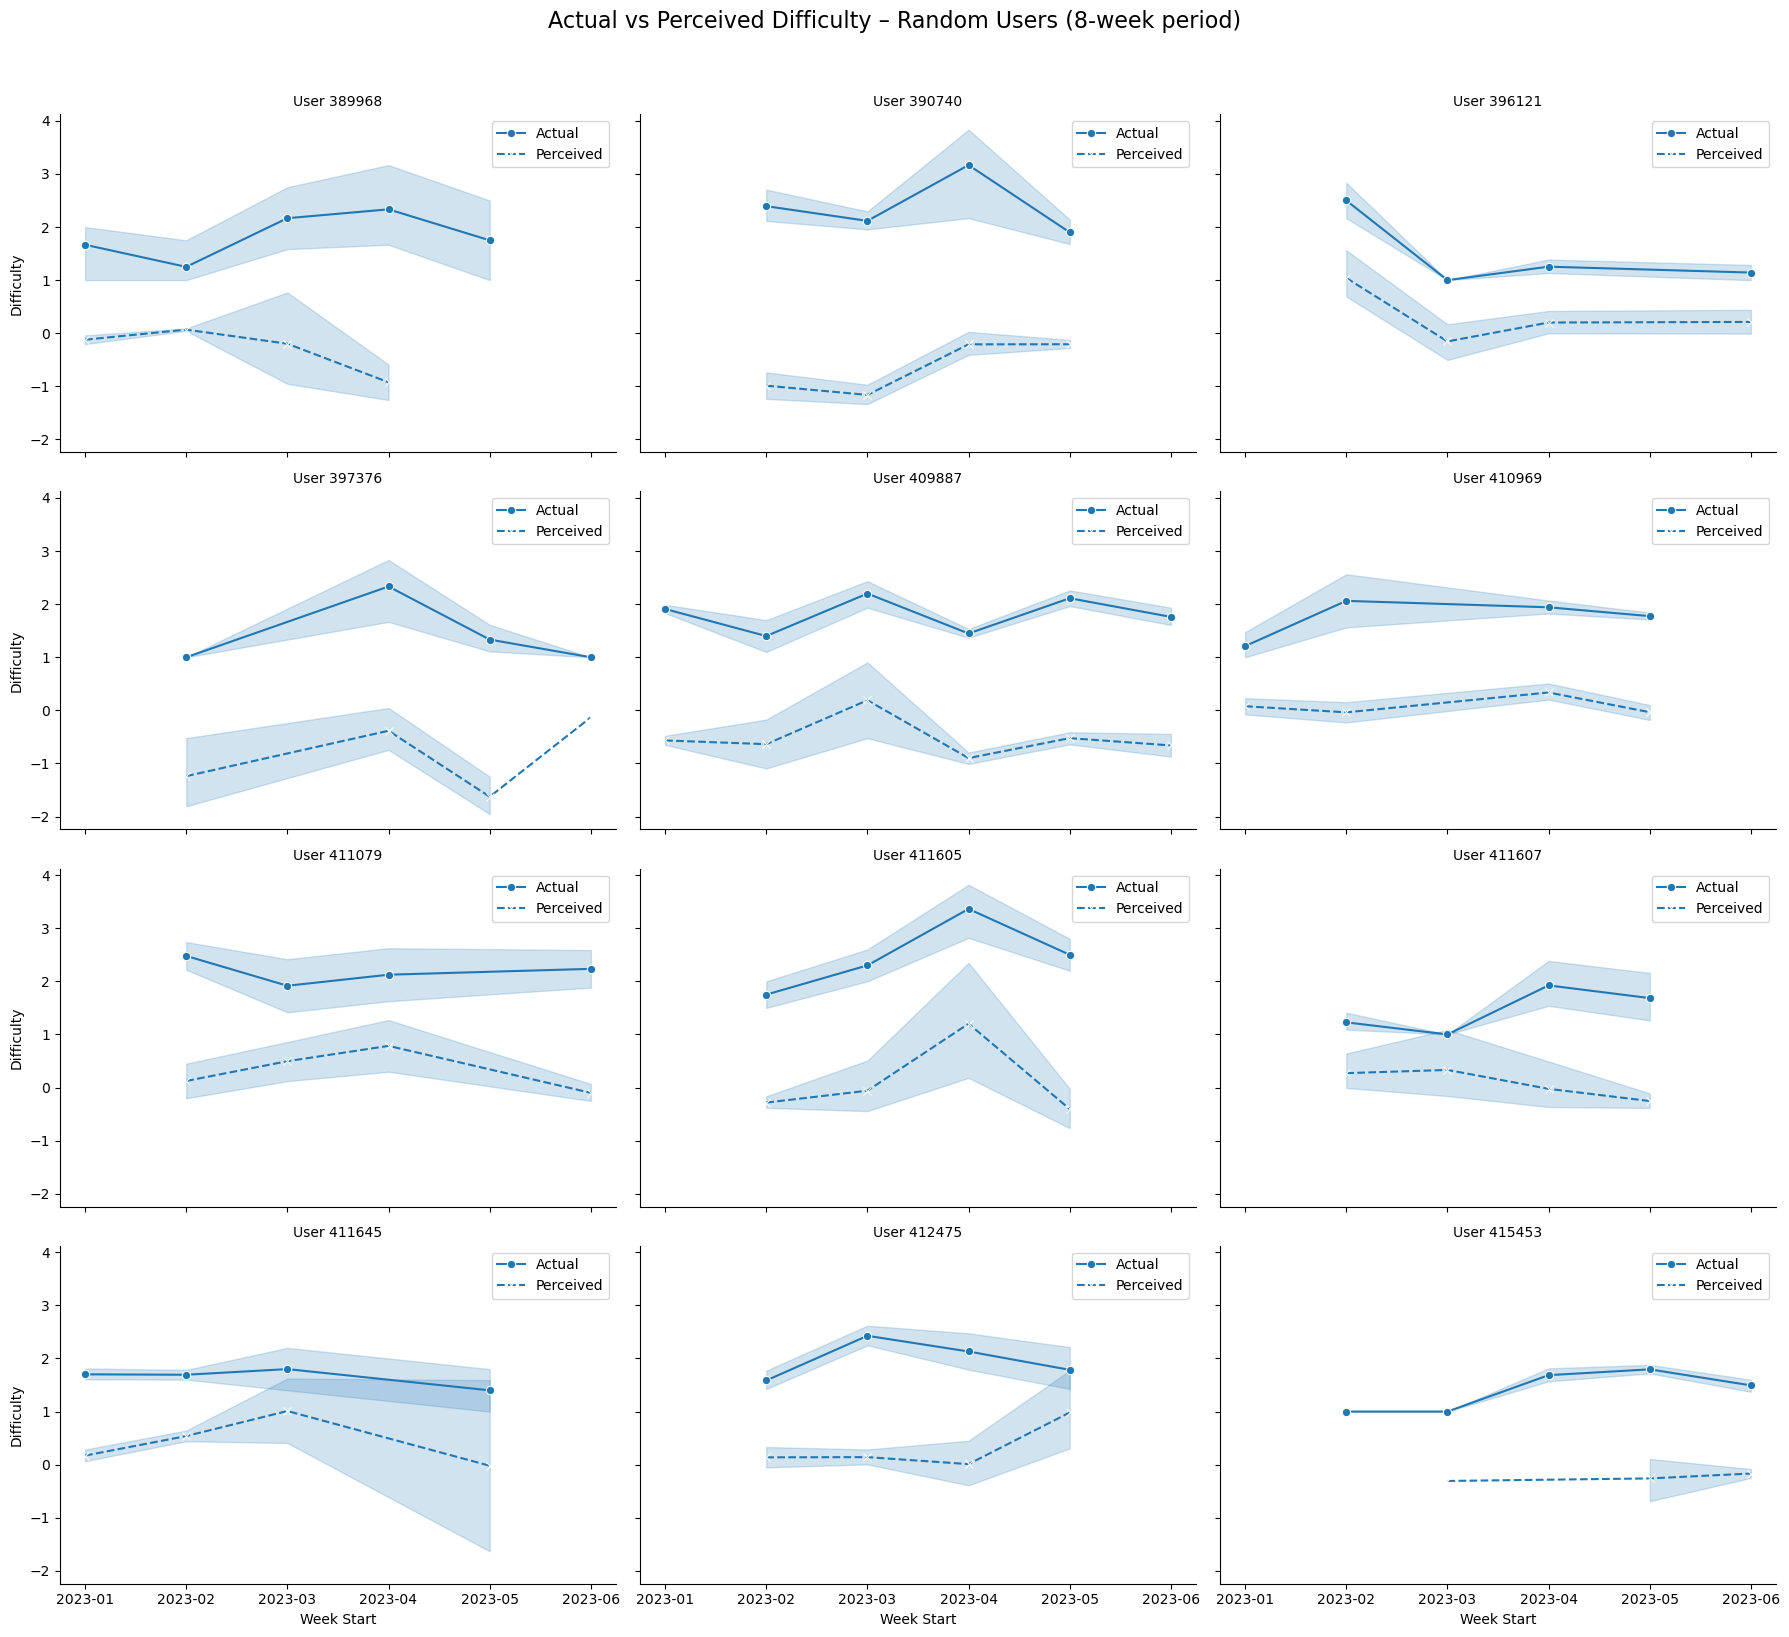

In [41]:
# Ensure date column is datetime
#topic_difficulty['year_week'] = pd.to_datetime(topic_difficulty['year_week'])
# Step 1: Pick your 8-week window (adjust these dates as needed)
start_date = pd.to_datetime("2023-01")  # inclusive
end_date = start_date + pd.Timedelta(weeks=8)  # exclusive

# Step 2: Filter to 8-week period
period_df = topic_difficulty[
    (topic_difficulty['date'] >= start_date) &
    (topic_difficulty['date'] < end_date)
].copy()

# Step 3: Keep users active at least twice
active_users = (
    period_df.groupby('user_id')['year_week']
    .nunique()
    .loc[lambda x: x >= 4]
    .index
)

# Step 4: Randomly sample 6 users from this group
sample_users = active_users.to_series().sample(12, random_state=42).values

# Step 5: Subset for plotting
plot_df = period_df[period_df['user_id'].isin(sample_users)]

# Step 6: Plot actual vs perceived difficulty
g = sns.FacetGrid(plot_df, col="user_id", col_wrap=3, height=4, aspect=1.5, sharey=True)

g.map_dataframe(sns.lineplot, x="year_week", y="difficulty", marker='o', label="Actual")
g.map_dataframe(sns.lineplot, x="year_week", y="perceived_difficulty", marker='x', linestyle='--', label="Perceived")

# Add legends to each subplot
for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles=handles, labels=["Actual", "Perceived"], loc='upper right')

g.set_titles("User {col_name}")
g.set_axis_labels("Week Start", "Difficulty")
g.fig.suptitle("Actual vs Perceived Difficulty – Random Users (8-week period)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Engagement over time per subject

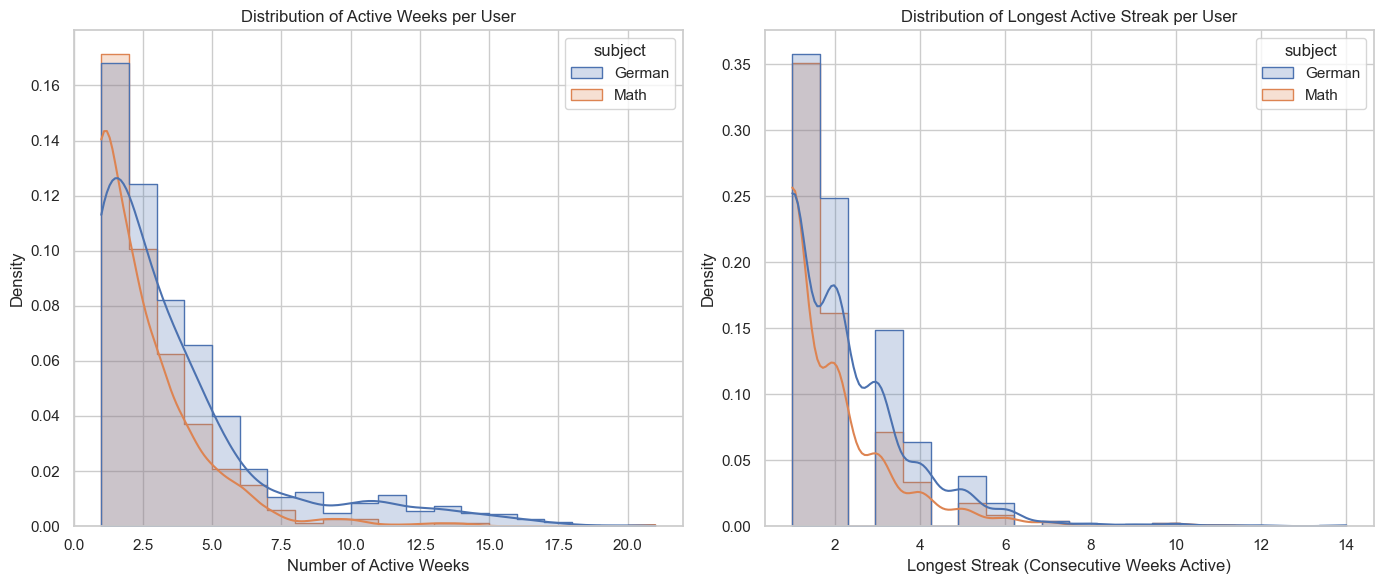

In [43]:
# Ensure data is sorted by user and time
df_model_sorted = df_model.sort_values(['user_id', 'year_week'])

# Function to calculate the longest consecutive streak
def longest_streak(series):
    streak = max_streak = 0
    for active in series:
        if active:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 0
    return max_streak

# Group by user and subject
metrics = []

for is_math, group in df_model_sorted.groupby('math'):
    subject = 'Math' if is_math == 1 else 'German'
    
    # Create a binary column for weekly activity
    group['was_active'] = group['engaged_next_week'] == 1
    
    for user_id, user_df in group.groupby('user_id'):
        if user_df['was_active'].sum() == 0:
            continue  # skip users never active
        
        user_df = user_df.sort_values('year_week')
        active_weeks = user_df['was_active'].sum()
        longest = longest_streak(user_df['was_active'])
        
        metrics.append({
            'user_id': user_id,
            'subject': subject,
            'active_weeks': active_weeks,
            'longest_streak': longest
        })

# Create a summary DataFrame
df_metrics = pd.DataFrame(metrics)

# Set style
sns.set(style='whitegrid')

# Plot: Active Weeks per Subject
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df_metrics, x='active_weeks', hue='subject', bins=20, kde=True, element='step', stat='density')
plt.title("Distribution of Active Weeks per User")
plt.xlabel("Number of Active Weeks")
plt.ylabel("Density")

# Plot: Longest Streak per Subject
plt.subplot(1, 2, 2)
sns.histplot(data=df_metrics, x='longest_streak', hue='subject', bins=20, kde=True, element='step', stat='density')
plt.title("Distribution of Longest Active Streak per User")
plt.xlabel("Longest Streak (Consecutive Weeks Active)")
plt.ylabel("Density")

plt.tight_layout()
plt.show()


In [44]:
summary = df_metrics.groupby('subject')[['active_weeks', 'longest_streak']].agg(['mean', 'median', 'std'])
print(summary)

        active_weeks                  longest_streak                 
                mean median       std           mean median       std
subject                                                              
German      3.578996    2.0  3.291467       2.217472    2.0  1.515536
Math        2.493047    2.0  2.044973       1.887484    1.0  1.360838


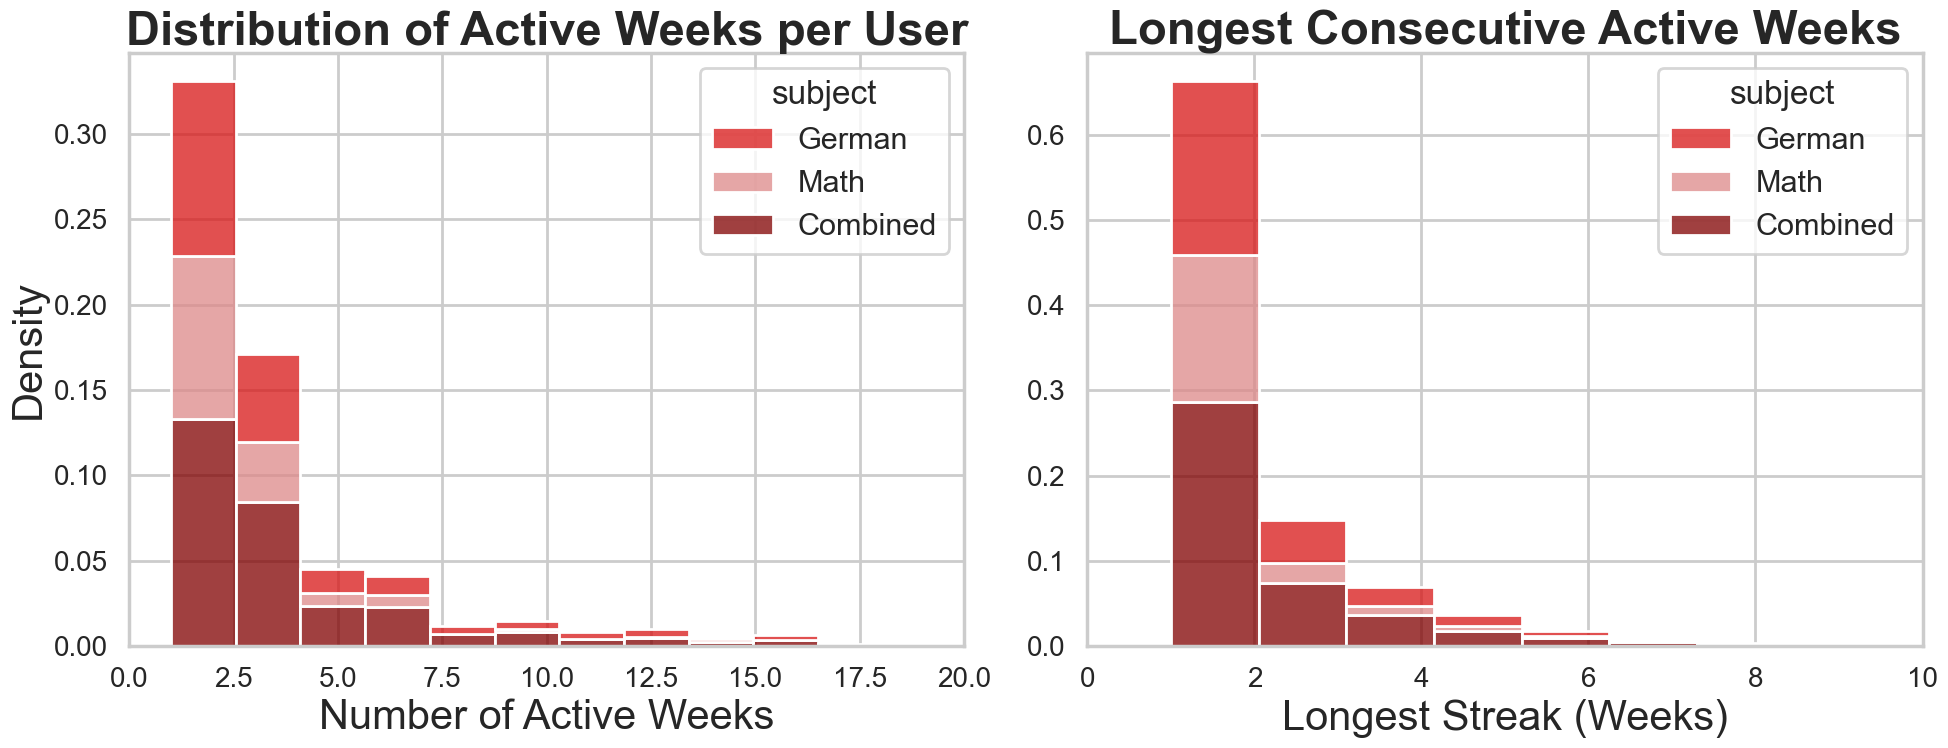

In [87]:
from itertools import chain

# Helper function
def longest_streak(series):
    streak = max_streak = 0
    for val in series:
        if val:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 0
    return max_streak

# Container for all results
metrics = []

# Individual subjects: Math and German
for is_math, group in df_model.sort_values(['user_id', 'year_week']).groupby('math'):
    subject = 'Math' if is_math == 1 else 'German'
    group['was_active'] = group['engaged_next_week'] == 1

    for user_id, user_df in group.groupby('user_id'):
        if user_df['was_active'].sum() == 0:
            continue
        streak = longest_streak(user_df['was_active'])
        metrics.append({
            'user_id': user_id,
            'subject': subject,
            'active_weeks': user_df['was_active'].sum(),
            'longest_streak': streak
        })

# Combined subject
combined = df_model.sort_values(['user_id', 'year_week']).copy()
combined['was_active'] = combined['engaged_next_week'] == 1

for user_id, user_df in combined.groupby('user_id'):
    if user_df['was_active'].sum() == 0:
        continue
    streak = longest_streak(user_df['was_active'])
    metrics.append({
        'user_id': user_id,
        'subject': 'Combined',
        'active_weeks': user_df['was_active'].sum(),
        'longest_streak': streak
    })

# Final DataFrame
df_metrics = pd.DataFrame(metrics)

# Poster-friendly settings
sns.set(style='whitegrid', context='poster')  # larger fonts

# Custom high-contrast colors
custom_palette = {
    'German': "#D81515FF",    # Red
    'Math': "#DD8888",      # Dark Red
    'Combined': "#800000"   # Deep Brown
}

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot: Active Weeks
sns.histplot(
    data=df_metrics, x='active_weeks', hue='subject',
    bins=20, stat='density', kde=False,
    multiple='stack', element='bars',  # filled bars
    palette=custom_palette, ax=axes[0], linewidth=2
)
axes[0].set_title("Distribution of Active Weeks per User", fontsize=34, weight='bold')
axes[0].set_xlabel("Number of Active Weeks", fontsize=30)
axes[0].set_xlim(0,20)
axes[0].set_ylabel("Density", fontsize=30)
axes[0].tick_params(axis='both', labelsize=20)
#axes[0].legend(title='Subject', fontsize=18, title_fontsize=20)

# Plot: Longest Streak
sns.histplot(
    data=df_metrics, x='longest_streak', hue='subject',
    bins=20, stat='density', kde=False,
    multiple='stack', element='bars',
    palette=custom_palette, ax=axes[1], linewidth=2
)
axes[1].set_title("Longest Consecutive Active Weeks", fontsize=34, weight='bold')
axes[1].set_xlabel("Longest Streak (Weeks)", fontsize=30)
axes[1].set_xlim(0,10)
axes[1].set_ylabel("", fontsize=32)
axes[1].tick_params(axis='both', labelsize=20)
#axes[1].legend(title='Subject', fontsize=18, title_fontsize=20)

plt.tight_layout()

# Optional: Save to file
plt.savefig("student_engagement_poster.png", dpi=300, bbox_inches='tight', transparent=True)

plt.show()